In [7]:
!date

Fri Jun 17 16:56:28 PDT 2022


# QC and within replicate batch effect examination
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [8]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [10]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

import gget

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [11]:
# set random seed
np.random.seed(926)

In [12]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Reference genome information
Assembly: bTaeGut1_v1.p, INSDC Assembly GCA_003957565.2, May 2019   
http://uswest.ensembl.org/Taeniopygia_guttata/Info/Index  
https://www.ebi.ac.uk/ena/browser/view/GCA_003957565.2?show=blobtoolkit  
Project: G10K-VGP Project, avian B10K Project.   
Gender: Male (Black17)  
DNA was collected from an inbred male in a laboratory colony Art Arnold at UCLA. The samples were prepared in the lab of Erich Jarvis, and sequencing was conducted at Pacific Biosciences, Bionano Genomics, 10X Genomics, Arima Genomics for HiC, and the Rockefeller University Vertebrate Genomes Lab.  
Note: This assembly represents the primary haplotype of the diploid genome Taeniopygia guttata and includes the chromosomes. The alternate haplotype sequences are in WGS project RRCC00000000. In May 2019 the mitochondrial sequence (RRCB01000135) was added to this 01 version of RRCB00000000. In October 2020 chromosomes 31-35 (CM025860-CM025865) were identified within the sequences of this 01 version of RRCB00000000 and the assembly name was updated to bTaeGut1.pri.v2 https://www.ncbi.nlm.nih.gov/assembly/GCA_003957565.4.

Downloaded from http://ftp.ensembl.org/pub/release-104/gtf/taeniopygia_guttata/ on March 20:
Taeniopygia_guttata.bTaeGut1_v1.p.104.abinitio...> 20-Mar-2021 10:29             2733364  
Taeniopygia_guttata.bTaeGut1_v1.p.104.chr.gtf.gz   20-Mar-2021 10:15            12851769  
Taeniopygia_guttata.bTaeGut1_v1.p.104.gtf.gz       20-Mar-2021 10:19            13460174  

Chromosomes built: 33 (of 40 total in the ZF genome)
Base Pairs: 1,057,995,280   
Golden Path Length: 1,057,995,280  
Annotation provider: Ensembl  
Annotation method: Full genebuild  
Genebuild started: May 2019  
Genebuild released: Dec 2019  
Genebuild last updated/patched: /  
Database version: 104.12  

##### Coding genes: 16,619
Non coding genes: 5,399  
Small non coding genes: 638  
Long non coding genes: 4,759  
Misc non coding genes: 2  
Pseudogenes: 132  
Gene transcripts: 38,869  

Genscan gene predictions: 37,466  
Short Variants: 1,581,781

General notes:
Number of chromosomes in zebrafinch: 2n=80
It is generally accepted that the zebra finch genome consists of seven macrochromosomes (Tgu1–Tgu5, Tgu1A and TguZ; Itoh and Arnold 2005) with an assembled size range of 62–156 Mb and 33 microchromosomes ranging from 9 kb to 40 Mb.

___

# Viral infection information
Experiment: GFP-tetx-PEST-WRE (driven by dlx-promoter)  
Control: neonGreen-WRE (driven by cag-promoter)

WRE added to reference genome because it should serve to detect both viral constructs. It is also the sequence closest to the polyA-tail and therefore the most likely to be captured. (I tried adding GFP, tetx, PEST and WRE to the ref genome as separate genes and could only detect WRE.)

___

# Load Anndata object from h5ads

Load data from control animal 1:

In [13]:
adata_1C = anndata.read('../../finchseq_data/kallisto_bustools/mm_FT-SA112356-ZSOFIA-1C/counts_unfiltered/adata.h5ad')
adata_1C

AnnData object with n_obs × n_vars = 972665 × 22151
    var: 'gene_name'

Load data from control animal 2:

In [14]:
adata_2C = anndata.read('../../finchseq_data/kallisto_bustools/mm_FT-SA112357-ZSOFIA-2C/counts_unfiltered/adata.h5ad')
adata_2C

AnnData object with n_obs × n_vars = 887875 × 22151
    var: 'gene_name'

Load data from experiment animal 1:

In [15]:
adata_3E = anndata.read('../../finchseq_data/kallisto_bustools/mm_FT-SA112358-ZSOFIA-3E/counts_unfiltered/adata.h5ad')
adata_3E

AnnData object with n_obs × n_vars = 999106 × 22151
    var: 'gene_name'

Load data from experiment animal 2:

In [16]:
adata_4E = anndata.read('../../finchseq_data/kallisto_bustools/mm_FT-SA112359-ZSOFIA-4E/counts_unfiltered/adata.h5ad')
adata_4E

AnnData object with n_obs × n_vars = 1282885 × 22151
    var: 'gene_name'

Add columns to obs:

In [17]:
adata_1C.obs["species"] = ["zebrafinch"] * adata_1C.n_obs
adata_1C.obs["batch"] = ["control1"] * adata_1C.n_obs

adata_2C.obs["species"] = ["zebrafinch"] * adata_2C.n_obs
adata_2C.obs["batch"] = ["control2"] * adata_2C.n_obs

adata_3E.obs["species"] = ["zebrafinch"] * adata_3E.n_obs
adata_3E.obs["batch"] = ["experiment1"] * adata_3E.n_obs

adata_4E.obs["species"] = ["zebrafinch"] * adata_4E.n_obs
adata_4E.obs["batch"] = ["experiment2"] * adata_4E.n_obs

Create list of adata objects:

In [18]:
adatas = [adata_1C, adata_2C, adata_3E, adata_4E]

___

# Check UMI counts for WRE before filtering
The experiment brids were infected with GFP-tetx-WRE (driven by dlx), and the control birds with neonGreen-WRE (driven by cag). We are aligning to WRE to find these sequences because it is shared between both viruses and it is closest to the polyA-tail (hence the chance that 10x picked up its full sequence is the highest).

In [19]:
# WRE
print("Total UMI counts for WRE in control 1: ", adata_1C[:, adata_1C.var.index.str.contains("WRE")].X.sum())
print("Total UMI counts for WRE in control 2: ", adata_2C[:, adata_2C.var.index.str.contains("WRE")].X.sum())
print("Total UMI counts for WRE in experiment 1: ", adata_3E[:, adata_3E.var.index.str.contains("WRE")].X.sum())
print("Total UMI counts for WRE in experiment 2: ", adata_4E[:, adata_4E.var.index.str.contains("WRE")].X.sum())

Total UMI counts for WRE in control 1:  9251.0
Total UMI counts for WRE in control 2:  7071.0
Total UMI counts for WRE in experiment 1:  276.0
Total UMI counts for WRE in experiment 2:  382.0


___

# Set colors, titles and fontsize for plotting:

In [20]:
colors = ["#0571b0", "#a6cee3", "#e66101", "#fdb863"]
filter_colors = ["#cde7f7", "#e4f1f7", "#f7dbc6", "#ffe8cc"]
titles = ["Control 1", "Control 2", "TetX 1", "TetX 2"]
fontsize = 20

___

# Basic Filtering

### Knee plots and saturation plots before filtering

In [21]:
# Expected number of cells in order of control1, control2, experiment1, experiment2:
expected_num_cells = [9769, 6060, 7707, 12306] # based on cell counts obtained after bustools filtering

In [22]:
def yex(ax, col="k", alpha=0.75):
    """
    Funciton to add linear graph to plot.
    Call after defining x and y scales
    """
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # Plot both limits against each other
    ax.plot(lims, lims, col, alpha=alpha, zorder=1)
    ax.set(**{
        "aspect": "equal",
        "xlim": lims,
        "ylim": lims
    })
    return ax

In [23]:
# fig, axs = plt.subplots(figsize=(30, 14), ncols=4, nrows=2, sharex='col', sharey='row', constrained_layout=True)
# axs_row1 = [axs[0][0], axs[0][1], axs[0][2], axs[0][3]]
# axs_row2 = [axs[1][0], axs[1][1], axs[1][2], axs[1][3]]

# # Plot knee plots in first row
# for ax,(i, adata) in zip(axs_row1, enumerate(adatas)):

#     knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    
#     # Create masks for cells that will be kept/filtered out based on minimum UMI count
#     min_umi = knee[expected_num_cells[i]]
#     keep_mask = np.ma.masked_where(knee > min_umi, knee).mask
#     filter_mask = np.invert(keep_mask)
    
# #     # Plot all cells in filter out color
# #     ax.loglog(knee, range(len(knee)), linewidth=5, color=filter_colors[i])
# #     # Overlay with cells to keep in dark color
# #     ax.loglog(knee[keep_mask], range(len(knee[keep_mask])), linewidth=5, color=colors[i])
    
#     # Plot all cells in filter out color
#     ax.plot(knee, range(len(knee)), linewidth=5, color=filter_colors[i])
#     # Overlay with cells to keep in dark color
#     ax.plot(knee[keep_mask], range(len(knee[keep_mask])), linewidth=5, color=colors[i])
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     # Add lines to show filtering cut offs
#     ax.axvline(x=knee[expected_num_cells[i]], linewidth=1.5, color="k", ls="--")
#     ax.axhline(y=expected_num_cells[i], linewidth=1.5, color="k", ls="--")

#     # Define axis labels and title
# #     ax.set_xlabel("UMI Counts", fontsize=fontsize)
#     if i == 0:
#         ax.set_ylabel("Set of Barcodes", fontsize=fontsize)
#     ax.set_title(titles[i], fontsize=fontsize+2)
    
#     # Change fontsize of tick labels
#     ax.tick_params(axis="both", labelsize=fontsize)
    
#     # Set x and y lim to be the same as for the library sat plot
#     ax.set_xlim(1, 10**6)
#     ax.set_ylim(1, 10**6)
    
#     # Add grid and set below graph
#     ax.grid(True, which="both", color="lightgray")
#     ax.set_axisbelow(True)
    
#     # Add invisible linear graph to match square library sat plot
#     yex(ax, alpha=0)

# # Plot library saturation plots in second row
# for ax,(i, adata) in zip(axs_row2, enumerate(adatas)):
#     # Number of UMI counts per cell
#     x = np.asarray(adata.X.sum(axis=1))[:,0]
#     # Number of different genes detected per cell
#     y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
    
#     # Create masks for cells that will be kept/filtered out based on minimum UMI count from knee plot
#     knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
#     min_umi = knee[expected_num_cells[i]]
#     keep_mask = np.ma.masked_where(x > min_umi, x).mask
#     filter_mask = np.invert(keep_mask)
    
#     ax.scatter(x[keep_mask], y[keep_mask], alpha=0.5, color=colors[i], zorder=2)
#     ax.scatter(x[filter_mask], y[filter_mask], alpha=0.5, color=filter_colors[i], zorder=2)
    
#     # Add lines to show filtering cut off
#     ax.axvline(x=min_umi, linewidth=1.5, color="k", ls="--", zorder=3)

#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     # Define axis labels and title
#     ax.set_xlabel("UMI Counts", fontsize=fontsize)
#     if i == 0:
#         ax.set_ylabel("Genes Detected", fontsize=fontsize)
# #     ax.set_title(titles[i], fontsize=fontsize+2)

#     # Change fontsize of tick labels
#     ax.tick_params(axis='both', labelsize=fontsize)
        
#     # Set x and y lim
#     ax.set_xlim(1, 10**6)
#     ax.set_ylim(1, 10**6)

#     # Add grid and set below graph
#     ax.set_axisbelow(True)
    
#     # Add linear graph
#     yex(ax)

# fig.savefig("figures/1_knee_+_library_sat_plots.png", dpi=300, bbox_inches='tight')  
# fig.savefig("figures/1_knee_+_library_sat_plots.pdf", dpi=300, bbox_inches='tight')

# fig.show()

Knee plot ref: https://liorpachter.wordpress.com/2019/06/24/rotating-the-knee-plot-and-related-yoga/

### Check expression of "mitochondrial" genes

Check if there are any genes marked as mitochondrial with "MT-":

In [24]:
gget.search("MT-", "tae")

Fri Jun 17 16:57:39 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 16:57:43 2022 INFO Total matches found: 0.
Fri Jun 17 16:57:43 2022 INFO Query time: 4.76 seconds.


Empty DataFrame
Columns: [ensembl_id, gene_name, ensembl_description, ext_ref_description, biotype, url]
Index: []

Since no genes are marked with the standard "MT-" format, let's make a list of searchwords commonly associated with mitochondrial genes:

In [25]:
# List of mitochondrial gene searchwords
mito_gene_sw = ["ATP synthase", "cytochrome c oxidase", "cytochrome b", "NADH ", "humanin", "tRNA"]

For each searchword, check if there are genes that match the searchword AND the searchword "mitochondrial":

In [26]:
search_results = []
for searchword in mito_gene_sw:
    search_results.append(gget.search([searchword, "mitochondrial"], "tae", andor="and"))

# Concatenate into a single data frame
df = pd.concat(search_results)
df

Fri Jun 17 16:57:44 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 16:57:46 2022 INFO Total matches found: 2.
Fri Jun 17 16:57:46 2022 INFO Query time: 2.93 seconds.
Fri Jun 17 16:57:47 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 16:57:49 2022 INFO Total matches found: 8.
Fri Jun 17 16:57:49 2022 INFO Query time: 3.0 seconds.
Fri Jun 17 16:57:50 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 16:57:52 2022 INFO Total matches found: 3.
Fri Jun 17 16:57:52 2022 INFO Query time: 3.05 seconds.
Fri Jun 17 16:57:53 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 16:57:55 2022 INFO Total matches found: 0.
Fri Jun 17 16:57:55 2022 INFO Query time: 2.92 seconds.
Fri Jun 17 16:57:56 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 16:57:58 2022 INFO Total matches found: 0.
Fri Jun 17 16:57:58 2022 INFO Query t

ensembl_id gene_name  \
0   ENSTGUG00000007278    ATPAF2   
1   ENSTGUG00000008394    ATPAF1   
0   ENSTGUG00000004109      None   
1   ENSTGUG00000005020     COX10   
2   ENSTGUG00000013468      None   
3   ENSTGUG00000019049      None   
4   ENSTGUG00000022808   COX7A2L   
5   ENSTGUG00000027006     COX11   
6   ENSTGUG00000029234     COX5B   
7   ENSTGUG00000029520      None   
0   ENSTGUG00000007619    UQCRC1   
1   ENSTGUG00000008947   UQCRFS1   
2   ENSTGUG00000009075    UQCRC2   
0   ENSTGUG00000002269     FARS2   
1   ENSTGUG00000002764     IARS2   
2   ENSTGUG00000003663      TRMU   
3   ENSTGUG00000004602      None   
4   ENSTGUG00000005000     LARS2   
5   ENSTGUG00000005225     MARS2   
6   ENSTGUG00000006015     EARS2   
7   ENSTGUG00000007880     AARS2   
8   ENSTGUG00000008828     CARS2   
9   ENSTGUG00000009090     MTFMT   
10  ENSTGUG00000009489     PARS2   
11  ENSTGUG00000012447     RARS2   
12  ENSTGUG00000012680      MTO1   
13  ENSTGUG00000013001     NARS2   
14  ENSTGUG00000013621   TRMT10C   
15  ENSTGUG00000017335     DARS2   
16  ENSTGUG00000021527     WARS2   
17  ENSTGUG00000027465      None   

                                  ensembl_description  \
0   ATP synthase mitochondrial F1 complex assembly...   
1   Taeniopygia guttata ATP synthase mitochondrial...   
0   Taeniopygia guttata cytochrome c oxidase subun...   
1   protoheme IX farnesyltransferase, mitochondria...   
2   cytochrome c oxidase assembly factor 4 homolog...   
3   Taeniopygia guttata cytochrome c oxidase subun...   
4   cytochrome c oxidase subunit 7A-related protei...   
5   cytochrome c oxidase assembly protein COX11, m...   
6   cytochrome c oxidase subunit 5B, mitochondrial...   
7   cytochrome c oxidase subunit 5A, mitochondrial...   
0   cytochrome b-c1 complex subunit 1, mitochondri...   
1   Taeniopygia guttata cytochrome b-c1 complex su...   
2   cytochrome b-c1 complex subunit 2, mitochondri...   
0   phenylalanyl-tRNA synthetase 2, mitochondrial ...   
1   isoleucyl-tRNA synthetase 2, mitochondrial [So...   
2   tRNA 5-methylaminomethyl-2-thiouridylate methy...   
3   threonyl-tRNA synthetase 2, mitochondrial [Sou...   
4   leucyl-tRNA synthetase 2, mitochondrial [Sourc...   
5   methionyl-tRNA synthetase 2, mitochondrial [So...   
6   glutamyl-tRNA synthetase 2, mitochondrial [Sou...   
7   alanyl-tRNA synthetase 2, mitochondrial [Sourc...   
8   cysteinyl-tRNA synthetase 2, mitochondrial [So...   
9   mitochondrial methionyl-tRNA formyltransferase...   
10  prolyl-tRNA synthetase 2, mitochondrial [Sourc...   
11  arginyl-tRNA synthetase 2, mitochondrial [Sour...   
12  mitochondrial tRNA translation optimization 1 ...   
13  asparaginyl-tRNA synthetase 2, mitochondrial [...   
14  tRNA methyltransferase 10C, mitochondrial RNas...   
15  aspartyl-tRNA synthetase 2, mitochondrial [Sou...   
16  tryptophanyl tRNA synthetase 2, mitochondrial ...   
17  serine--tRNA ligase, mitochondrial-like [Sourc...   

                                  ext_ref_description         biotype  \
0   ATP synthase mitochondrial F1 complex assembly...  protein_coding   
1   ATP synthase mitochondrial F1 complex assembly...  protein_coding   
0                                                None  protein_coding   
1   cytochrome c oxidase assembly factor heme A:fa...  protein_coding   
2                                                None  protein_coding   
3                                                None  protein_coding   
4               cytochrome c oxidase subunit 7A2 like  protein_coding   
5         cytochrome c oxidase copper chaperone COX11  protein_coding   
6                     cytochrome c oxidase subunit 5B  protein_coding   
7                                                None  protein_coding   
0     ubiquinol-cytochrome c reductase core protein 1  protein_coding   
1   ubiquinol-cytochrome c reductase, Rieske iron-...  protein_coding   
2     ubiquinol-cytochrome c reductase core protein 2  protein_coding   
0       phen

Find reference genome ID for each gene using Ensembl ID:

In [27]:
mito_gene_ids = []

for i, gene in enumerate(df["ensembl_id"].values):
    gene_name_id = []
    
    gni = adata_1C.var.iloc[np.where(adata_1C.var.index.str.startswith(gene))]

    if len(gni) > 0:
        gene_name_id = gni.index[0]
    else:
        gene_name_id = np.nan

    mito_gene_ids.append(gene_name_id)

In [28]:
# # Check if IDs were found correctly
# df_test = pd.DataFrame()
# df_test["ensembl_id"] = df["ensembl_id"]
# df_test["tae_id"] = mito_gene_ids
# df_test

Now we have a list of mitochondrial genes by their gene ID (mito_gene_ids)! Let's overlay the faction of mitochondrial counts with the library saturation plot:

control1 - Maximum total UMI count for all 'mitochondrial' genes in one cell: 199.1855010986328.


/home/lauraluebbert/bin/miniconda3/envs/diffexpr/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


control2 - Maximum total UMI count for all 'mitochondrial' genes in one cell: 130.02981567382812.
experiment1 - Maximum total UMI count for all 'mitochondrial' genes in one cell: 207.02630615234375.
experiment2 - Maximum total UMI count for all 'mitochondrial' genes in one cell: 252.3459014892578.


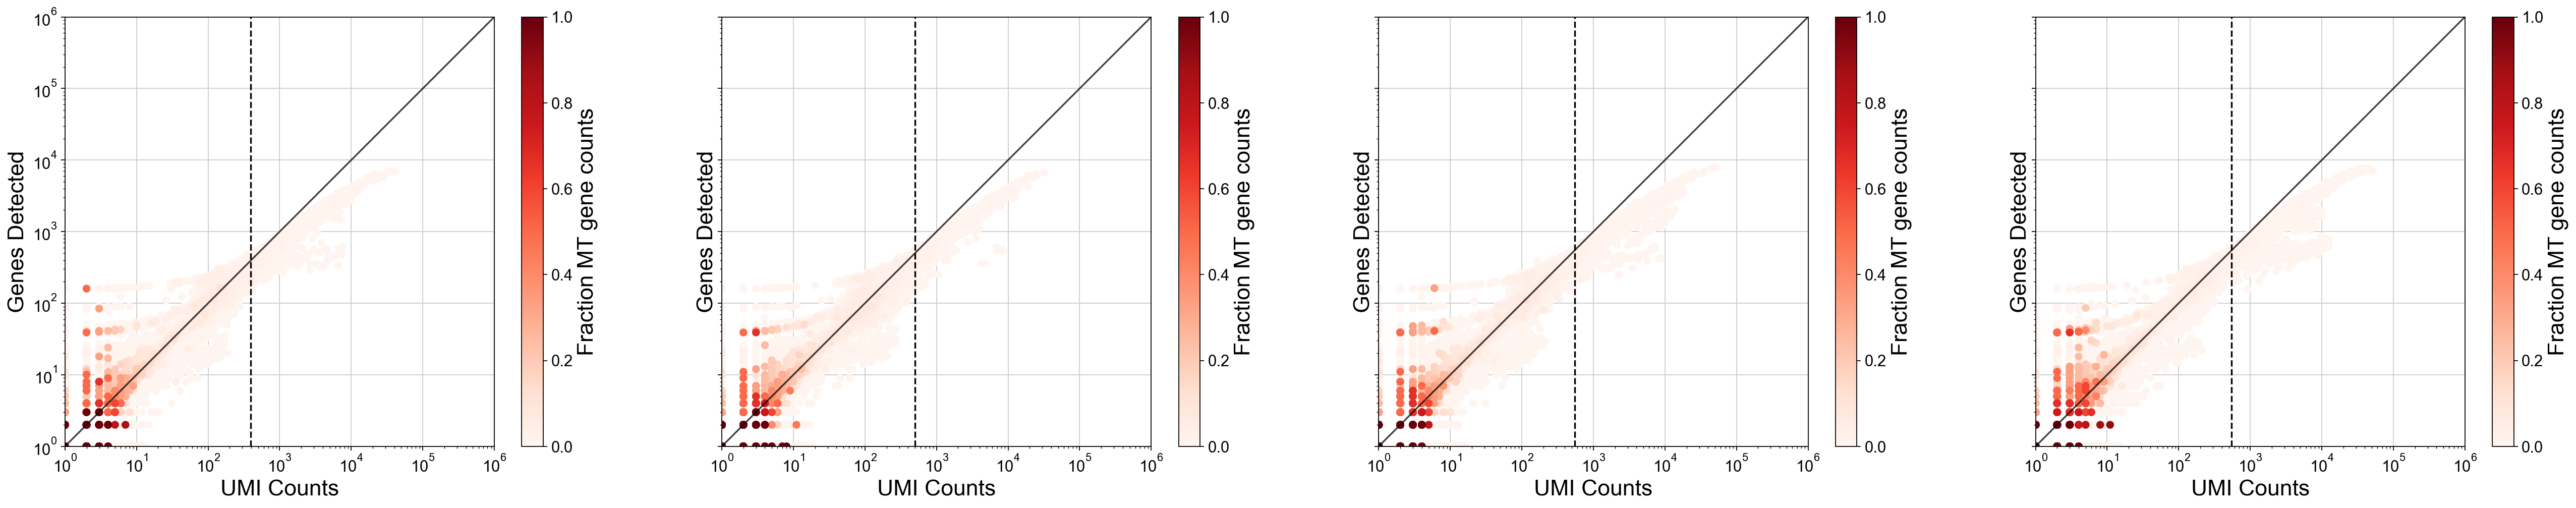

In [31]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4, sharey=True)

for ax,(i, adata) in zip(axs, enumerate(adatas)):
    
    # Calculate the sum counts of all mito genes per cell
    total_mito_exp = []
    for idx, gene in enumerate(mito_gene_ids):
        gene_exp = nd(adata[:, adata.var.index.str.contains(gene)].X.todense())
        if idx == 0:
            total_mito_exp = gene_exp
        else:
            # Add the expression of this mito gene to the list
            total_mito_exp = total_mito_exp + gene_exp
    
    print(f"{adata.obs['batch'][0]} - Maximum total UMI count for all 'mitochondrial' genes in one cell: {total_mito_exp.max()}.")

    # Calculate the fraction of the total sum per cell
    total_mito_fraction = total_mito_exp / adata.X.sum(axis=1).A1

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = total_mito_fraction
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    
    # Add a colorbar legend to the last graph
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(label="Fraction MT gene counts", fontsize=fontsize)
    
    # Add lines to show filtering cut off
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    min_umi = knee[expected_num_cells[i]]
    ax.axvline(x=min_umi, linewidth=1.5, color="k", ls="--", zorder=3)   

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
#     ax.set_title(titles[i], fontsize=fontsize+2)
    yex(ax)
    ax.set_axisbelow(True)
    
fig.savefig("figures/1_library_sat_mito_fraction.png", dpi=300, bbox_inches='tight')  
fig.savefig("figures/1_library_sat_mito_fraction.pdf", dpi=300, bbox_inches='tight')  
fig.show()

Mitochondrial read counts are highest in cells that will not be filtered out. However, the counts are overall very low.

# Check expression of apoptosis genes

In [32]:
df = gget.search(["apoptosis inducing", "apoptosis enhancing"], "tae")
df

Fri Jun 17 17:21:56 2022 INFO Fetching results from database: taeniopygia_guttata_core_106_12
Fri Jun 17 17:21:58 2022 INFO Total matches found: 7.
Fri Jun 17 17:21:58 2022 INFO Query time: 4.71 seconds.


ensembl_id gene_name  \
0  ENSTGUG00000003526     NAIF1   
1  ENSTGUG00000004116     AIFM2   
2  ENSTGUG00000005167     AIFM1   
3  ENSTGUG00000010632     AIFM3   
4  ENSTGUG00000012902      None   
5  ENSTGUG00000024673     BLCAP   
6  ENSTGUG00000008335       AEN   

                                 ensembl_description  \
0  nuclear apoptosis inducing factor 1 [Source:NC...   
1  Taeniopygia guttata apoptosis inducing factor ...   
2  apoptosis inducing factor mitochondria associa...   
3  apoptosis inducing factor mitochondria associa...   
4  SIVA1 apoptosis inducing factor [Source:NCBI g...   
5  BLCAP apoptosis inducing factor [Source:NCBI g...   
6  apoptosis enhancing nuclease [Source:NCBI gene...   

                                 ext_ref_description         biotype  \
0                nuclear apoptosis inducing factor 1  protein_coding   
1  apoptosis inducing factor mitochondria associa...  protein_coding   
2  apoptosis inducing factor mitochondria associa...  protein_coding   
3  apoptosis inducing factor mitochondria associa...  protein_coding   
4                                               None  protein_coding   
5                    BLCAP apoptosis inducing factor  protein_coding   
6                       apoptosis enhancing nuclease  protein_coding   

                                                 url  
0  https://uswest.ensembl.org/taeniopygia_guttata...  
1  https://uswest.ensembl.org/taeniopygia_guttata...  
2  https://uswest.ensembl.org/taeniopygia_guttata...  
3  https://uswest.ensembl.org/taeniopygia_guttata...  
4  https://uswest.ensembl.org/taeniopygia_guttata...  
5  https://uswest.ensembl.org/taeniopygia_guttata...  
6  https://uswest.ensembl.org/taeniopygia_guttata...

Find reference genome ID for each gene using Ensembl ID:

In [33]:
apo_gene_ids = []

for i, gene in enumerate(df["ensembl_id"].values):
    gene_name_id = []
    
    gni = adata_1C.var.iloc[np.where(adata_1C.var.index.str.startswith(gene))]

    if len(gni) > 0:
        gene_name_id = gni.index[0]
    else:
        gene_name_id = np.nan

    apo_gene_ids.append(gene_name_id)

In [34]:
# # Check if IDs were found correctly
# df_test = pd.DataFrame()
# df_test["ensembl_id"] = df["ensembl_id"]
# df_test["tae_id"] = apo_gene_ids
# df_test

Overlay the faction of apoptosis inducing gene counts with the library saturation plot:

control1 - Maximum total UMI count for all apoptosis inducing genes in one cell: 17.0.


/home/lauraluebbert/bin/miniconda3/envs/diffexpr/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


control2 - Maximum total UMI count for all apoptosis inducing genes in one cell: 10.0.
experiment1 - Maximum total UMI count for all apoptosis inducing genes in one cell: 14.0.
experiment2 - Maximum total UMI count for all apoptosis inducing genes in one cell: 12.0.


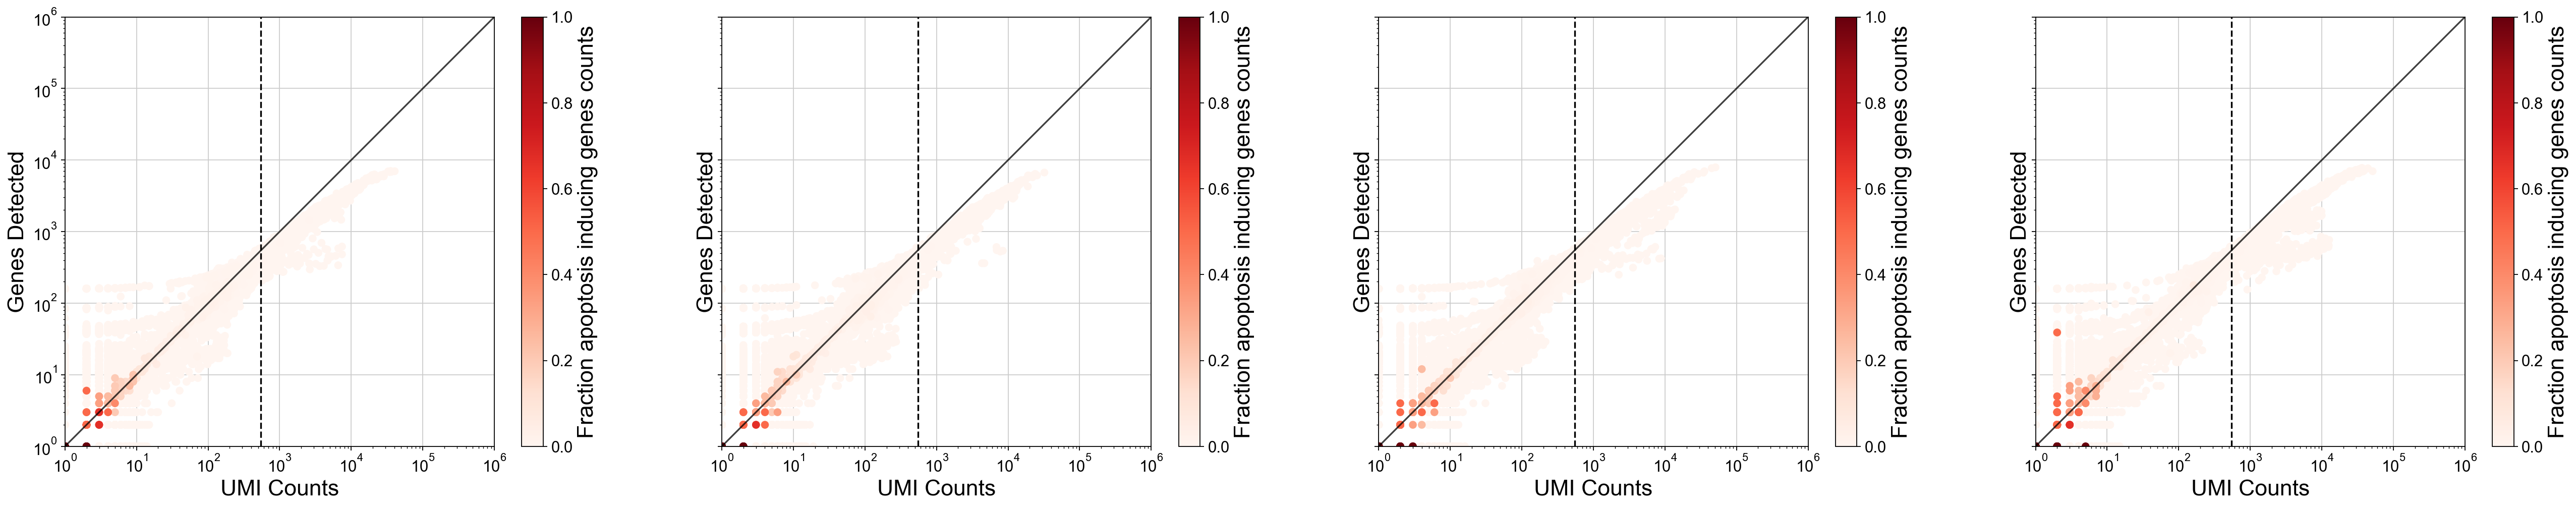

In [35]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4, sharey = True)

for ax,(i, adata) in zip(axs, enumerate(adatas)):
    
    # Calculate the sum counts of all apoptosis genes per cell
    total_apo_exp = []
    for idx, gene in enumerate(apo_gene_ids):
        gene_exp = nd(adata[:, adata.var.index.str.contains(gene)].X.todense())
        if idx == 0:
            total_apo_exp = gene_exp
        else:
            # Add the expression of this apoptosis gene to the list
            total_apo_exp = total_apo_exp + gene_exp
    
    print(f"{adata.obs['batch'][0]} - Maximum total UMI count for all apoptosis inducing genes in one cell: {total_apo_exp.max()}.")

    # Calculate the fraction of the total sum per cell
    total_apo_fraction = total_apo_exp / adata.X.sum(axis=1).A1

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = total_apo_fraction
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    
    # Add a colorbar
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(label="Fraction apoptosis inducing genes counts", fontsize=fontsize)
    
    # Add lines to show filtering cut off
    ax.axvline(x=min_umi, linewidth=1.5, color="k", ls="--", zorder=3)   
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
#     ax.set_title(titles[i], fontsize=fontsize+2)
    yex(ax)
    ax.set_axisbelow(True)
    
fig.savefig("figures/1_library_sat_apo_fraction.png", dpi=300, bbox_inches='tight')  
fig.savefig("figures/1_library_sat_apo_fraction.pdf", dpi=300, bbox_inches='tight')  
fig.show()

/home/lauraluebbert/bin/miniconda3/envs/diffexpr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


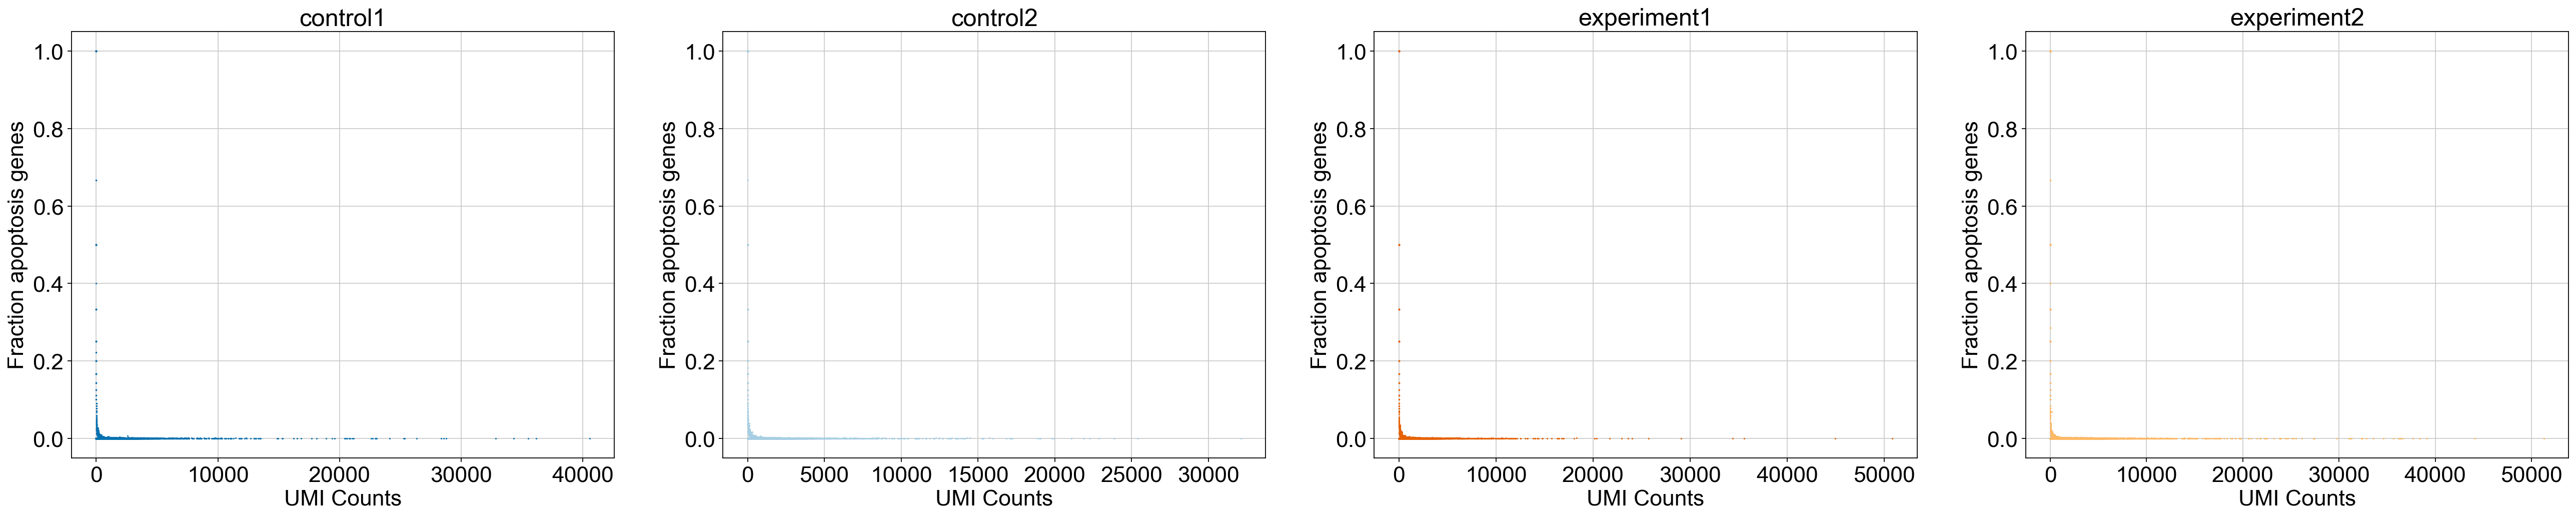

In [36]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4)

for ax,(i, adata) in zip(axs, enumerate(adatas)):
    adata.obs['percent_apo'] = np.sum(adata[:, apo_gene_ids].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # Add the total UMI counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1

    ax.scatter(adata.obs["n_counts"].values, adata.obs["percent_mito"].values, color=colors[i], s=0.2)
    
    # Define axis labels and title
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Fraction apoptosis genes", fontsize=fontsize)
    ax.set_title(f"{adata.obs['batch'][0]}", fontsize=fontsize+2)

    # Change fontsize of tick labels
    ax.tick_params(axis='both', labelsize=fontsize)

    # Add grid and set below graph
    ax.set_axisbelow(True)

### Filter based on minimum number of UMI counts from knee plot:

In [14]:
knee = np.sort((np.array(adata_1C.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[0]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_1C.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_1C = adata_1C[np.asarray(adata_1C.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_1C.obs['n_counts_processed'] = adata_1C.X.sum(axis=1)

print(adata_1C)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for control1 is: 391.0
AnnData object with n_obs × n_vars = 9763 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [15]:
knee = np.sort((np.array(adata_2C.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[1]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_2C.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_2C = adata_2C[np.asarray(adata_2C.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_2C.obs['n_counts_processed'] = adata_2C.X.sum(axis=1)

print(adata_2C)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for control2 is: 499.0
AnnData object with n_obs × n_vars = 6047 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [16]:
knee = np.sort((np.array(adata_3E.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[2]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_3E.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_3E = adata_3E[np.asarray(adata_3E.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_3E.obs['n_counts_processed'] = adata_3E.X.sum(axis=1)

print(adata_3E)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for experiment1 is: 549.0
AnnData object with n_obs × n_vars = 7706 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [17]:
knee = np.sort((np.array(adata_4E.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[3]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_4E.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_4E = adata_4E[np.asarray(adata_4E.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_4E.obs['n_counts_processed'] = adata_4E.X.sum(axis=1)

print(adata_4E)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for experiment2 is: 549.0
AnnData object with n_obs × n_vars = 12288 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


n_obs is pretty close to the expected number of cells (approx 10k).

#### Mean UMIs for each batch

In [19]:
print("Mean UMI count per cell for control1: " + str(adata_1C.X.sum(axis=1).mean()))
print("Mean UMI count per cell for control2: " + str(adata_2C.X.sum(axis=1).mean()))
print("Mean UMI count per cell for experiment1: " + str(adata_3E.X.sum(axis=1).mean()))
print("Mean UMI count per cell for experiment2: " + str(adata_4E.X.sum(axis=1).mean()))

Mean UMI count per cell for control1: 1580.7656
Mean UMI count per cell for control2: 1747.6652
Mean UMI count per cell for experiment1: 1852.4244
Mean UMI count per cell for experiment2: 2265.4285


#### Total UMI count for each batch

In [20]:
print("Total UMI count per cell for control1: ", adata_1C.X.sum())
print("Total UMI count per cell for control2: ", adata_2C.X.sum())
print("Total UMI count per cell for experiment1: ", adata_3E.X.sum())
print("Total UMI count per cell for experiment2: ", adata_4E.X.sum())

Total UMI count per cell for control1:  15433015.0
Total UMI count per cell for control2:  10568132.0
Total UMI count per cell for experiment1:  14274784.0
Total UMI count per cell for experiment2:  27837586.0


___

# Check UMI and cell counts for WRE after filtering

In [21]:
# WRE
print("Total UMI counts for WRE in control 1: ", adata_1C[:, adata_1C.var.index.str.contains("WRE")].X.sum())
print("Total UMI counts for WRE in control 2: ", adata_2C[:, adata_2C.var.index.str.contains("WRE")].X.sum())
print("Total UMI counts for WRE in experiment 1: ", adata_3E[:, adata_3E.var.index.str.contains("WRE")].X.sum())
print("Total UMI counts for WRE in experiment 2: ", adata_4E[:, adata_4E.var.index.str.contains("WRE")].X.sum())

Total UMI counts for WRE in control 1:  4091.0
Total UMI counts for WRE in control 2:  2751.0
Total UMI counts for WRE in experiment 1:  51.0
Total UMI counts for WRE in experiment 2:  72.0


In [22]:
print("# of cells with counts for WRE / total # of cells in control 1: ", len(adata_1C[adata_1C[:, adata_1C.var.index.str.contains("WRE")].X > 0]), " / ", len(adata_1C))
print("# of cells with counts for WRE / total # of cells in control 2: ", len(adata_2C[adata_2C[:, adata_2C.var.index.str.contains("WRE")].X > 0]), " / ", len(adata_2C))
print("# of cells with counts for WRE / total # of cells in experiment 1: ", len(adata_3E[adata_3E[:, adata_3E.var.index.str.contains("WRE")].X > 0]), " / ", len(adata_3E))
print("# of cells with counts for WRE / total # of cells in experiment 2: ", len(adata_4E[adata_4E[:, adata_4E.var.index.str.contains("WRE")].X > 0]), " / ", len(adata_4E))

# of cells with counts for WRE / total # of cells in control 1:  1434  /  9763
# of cells with counts for WRE / total # of cells in control 2:  966  /  6047
# of cells with counts for WRE / total # of cells in experiment 1:  39  /  7706
# of cells with counts for WRE / total # of cells in experiment 2:  56  /  12288


___

# Data quality check

In [23]:
# Create list of cleaned up adata objects
adatas = [adata_1C, adata_2C, adata_3E, adata_4E]

### Test for library saturation

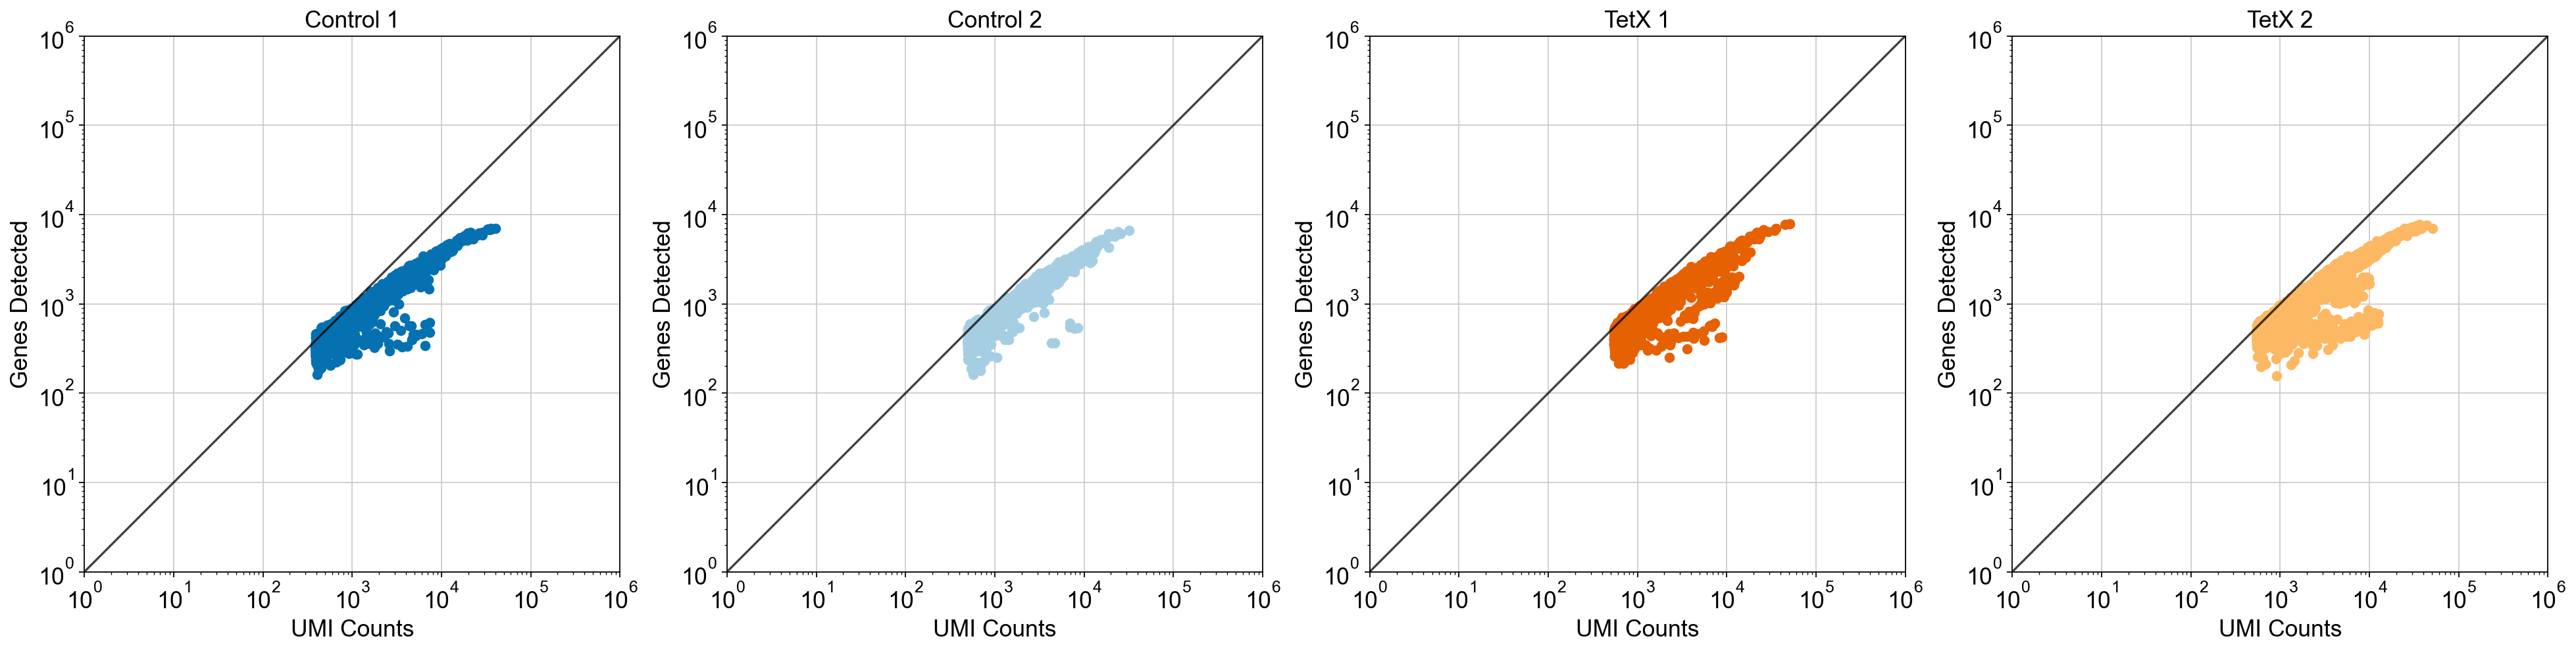

In [24]:
fig, axs = plt.subplots(figsize=(30,7), ncols=4)

for ax,(i, adata) in zip(axs, enumerate(adatas)):
    # Number of UMI counts per cell
    x = np.asarray(adata.X.sum(axis=1))[:,0]
    # Number of different genes detected per cell
    y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

#     # histogram definition
#     bins = [1500, 1500] # number of bins

#     # histogram the data
#     hh, locx, locy = np.histogram2d(x, y, bins=bins)

#     # Sort the points by density, so that the densest points are plotted last
#     z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
#     idx = z.argsort()
#     x2, y2, z2 = x[idx], y[idx], z[idx]

    scatter = ax.scatter(x, y, color=colors[i])
#     scatter = ax.scatter(x2, y2, c=z2, s=5, cmap='viridis') 
#     fig.colorbar(scatter, ax=ax, label="Barcodes")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title(titles[i], fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

    yex(ax)

    # Set grid below plot
    ax.set_axisbelow(True)

fig.savefig("figures/1_library_sat.png", dpi=300, format='png', bbox_inches='tight')  
    
fig.show()

For reference: This is what a more saturated data set looks like https://github.com/pachterlab/BYVSTZP_2020/blob/master/analysis/notebooks/final-10x_saturation_curves.ipynb

### Overlay expression of mito/apoptosis genes to see if extra arm contains dying cells:

Mitochondrial/apoptosis marker genes: MCU (ENSTGUG00000004428), AIFM1 (ENSTGUG00000005167), CASP3 (ENSTGUG00000006682)

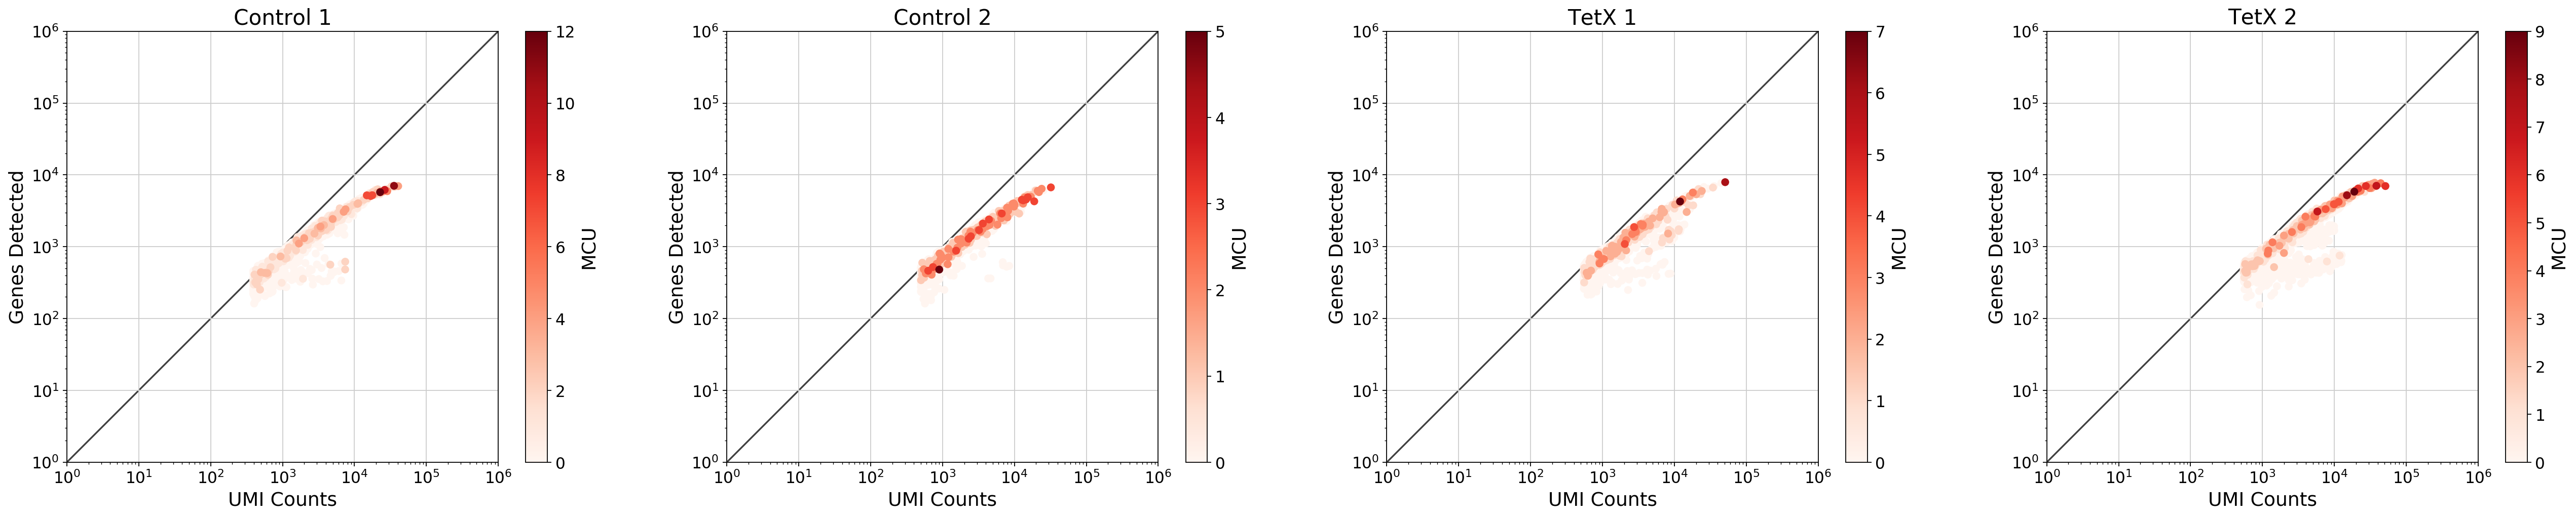

In [143]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4)

for ax,(i, adata) in zip(axs, enumerate(adatas)):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000004428")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(label="MCU", fontsize=fontsize)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title(titles[i], fontsize=fontsize+2)
    yex(ax)
    ax.set_axisbelow(True)
    
fig.savefig("figures/1_library_sat_MCU.png", dpi=300, format='png', bbox_inches='tight')  

fig.show()

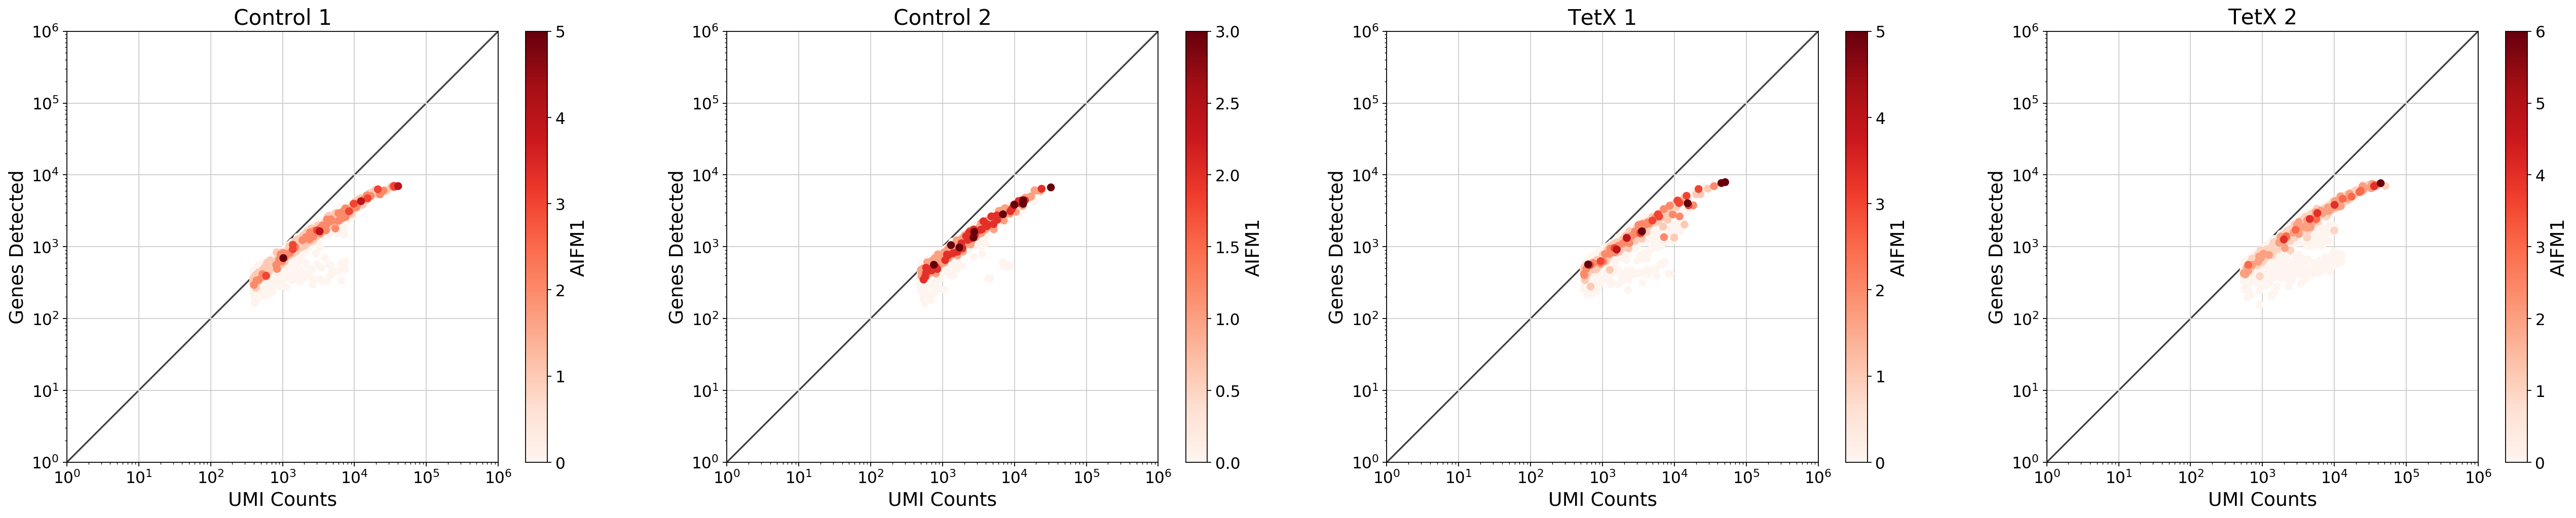

In [141]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4)

for ax,(i, adata) in zip(axs, enumerate(adatas)):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000005167")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(label="AIFM1", fontsize=fontsize)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title(titles[i], fontsize=fontsize+2)
    yex(ax)
    ax.set_axisbelow(True)

fig.show()

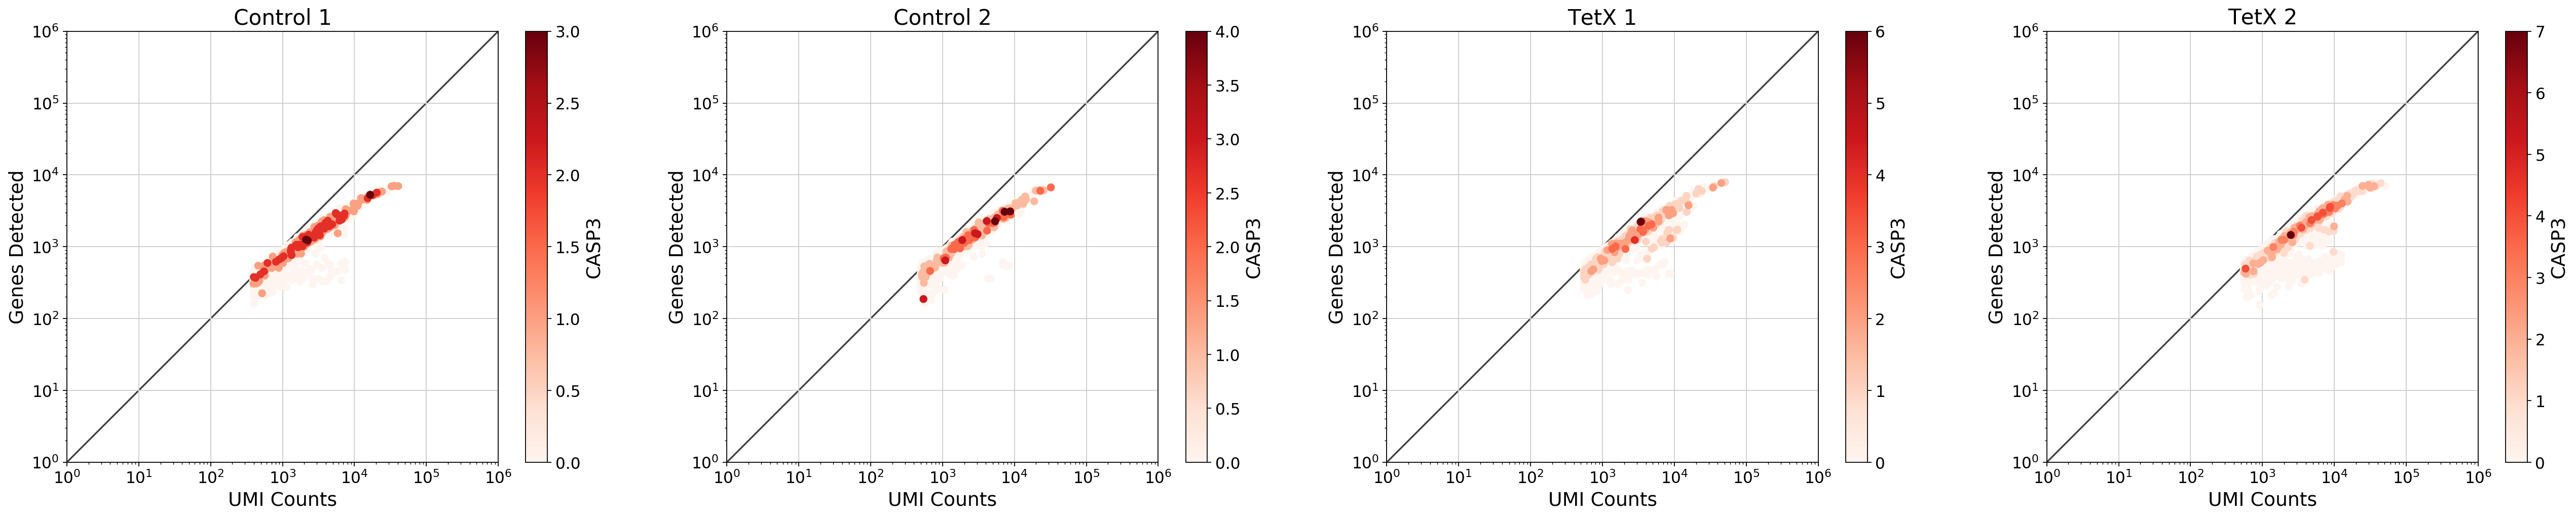

In [142]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4)

for ax,(i, adata) in zip(axs, enumerate(adatas)):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000006682")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(label="CASP3", fontsize=fontsize)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title(titles[i], fontsize=fontsize+2)
    yex(ax)
    ax.set_axisbelow(True)

fig.show()

Based on the low UMI counts of these markers the cells look very healthy. It does not look like the cells in the second arm express these apoptosis and mitochondrial marker genes at a higher level than other cells.

___

Color for WRE in library saturation plot:

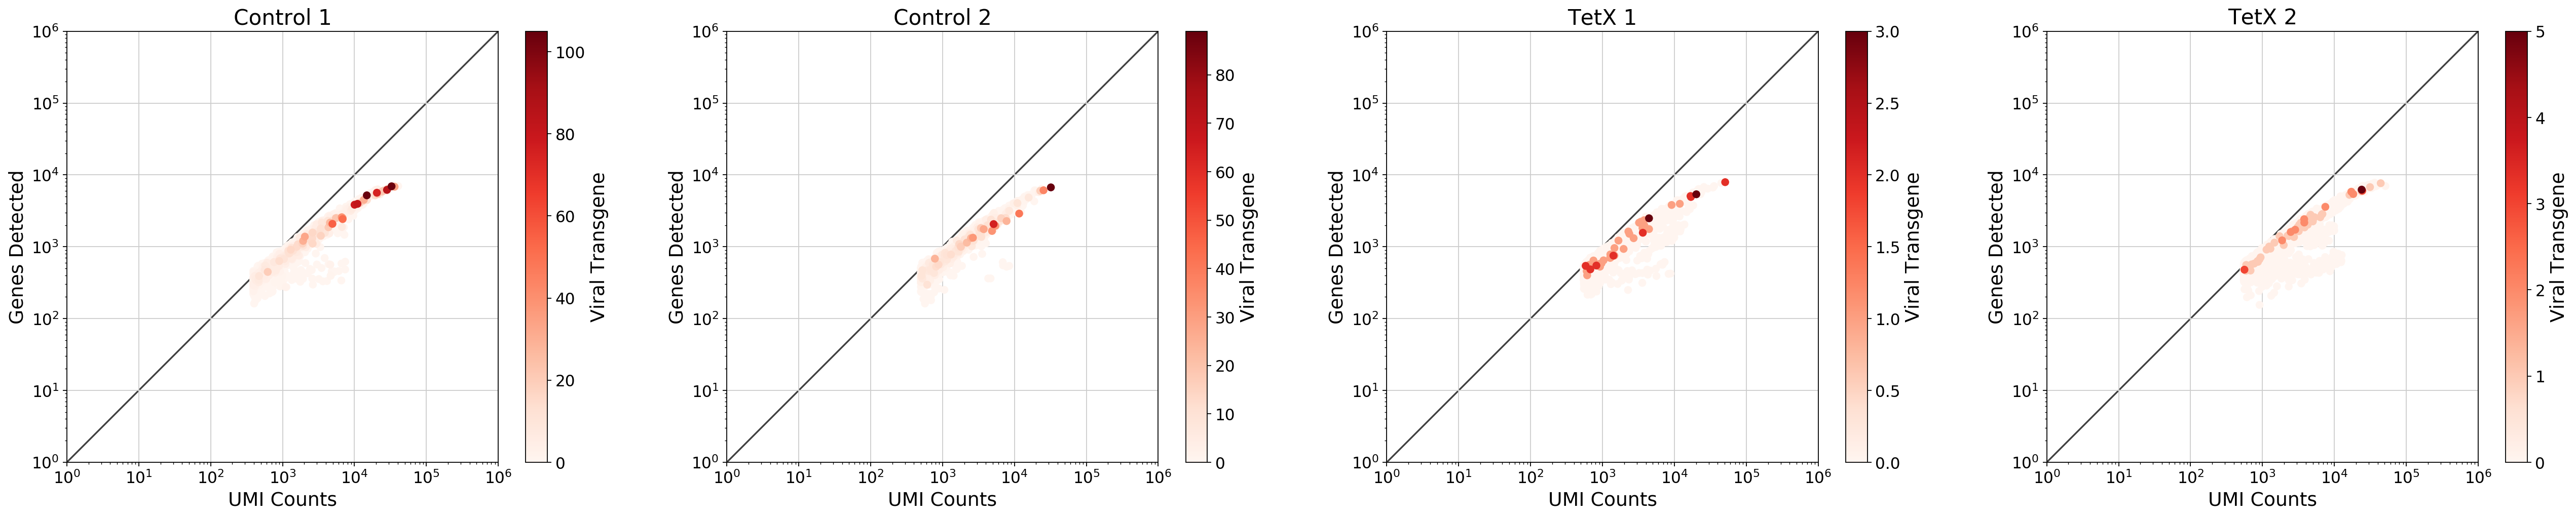

In [60]:
fig, axs = plt.subplots(figsize=(40,7), ncols=4)

for ax,(i, adata) in zip(axs, enumerate(adatas)):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("WRE")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(label="Viral Transgene", fontsize=fontsize)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts", fontsize=fontsize)
    ax.set_ylabel("Genes Detected", fontsize=fontsize)
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title(titles[i], fontsize=fontsize+2)
    yex(ax)
    # Set grid below plot
    ax.set_axisbelow(True)

# plt.tight_layout()
fig.savefig("figures/1_library_sat_WRE.png", dpi=300, format='png')    
    
fig.show()

It does not look like cells expressing the viral vector fall into the second arm.

___

# If not dying or virus-infected cells, then what are those cells in the second arm of the library saturation plot?

Define cutoffs that separate the side "arm" from the main data:

In [61]:
x_cutoff = 2500
y_cutoff = 950

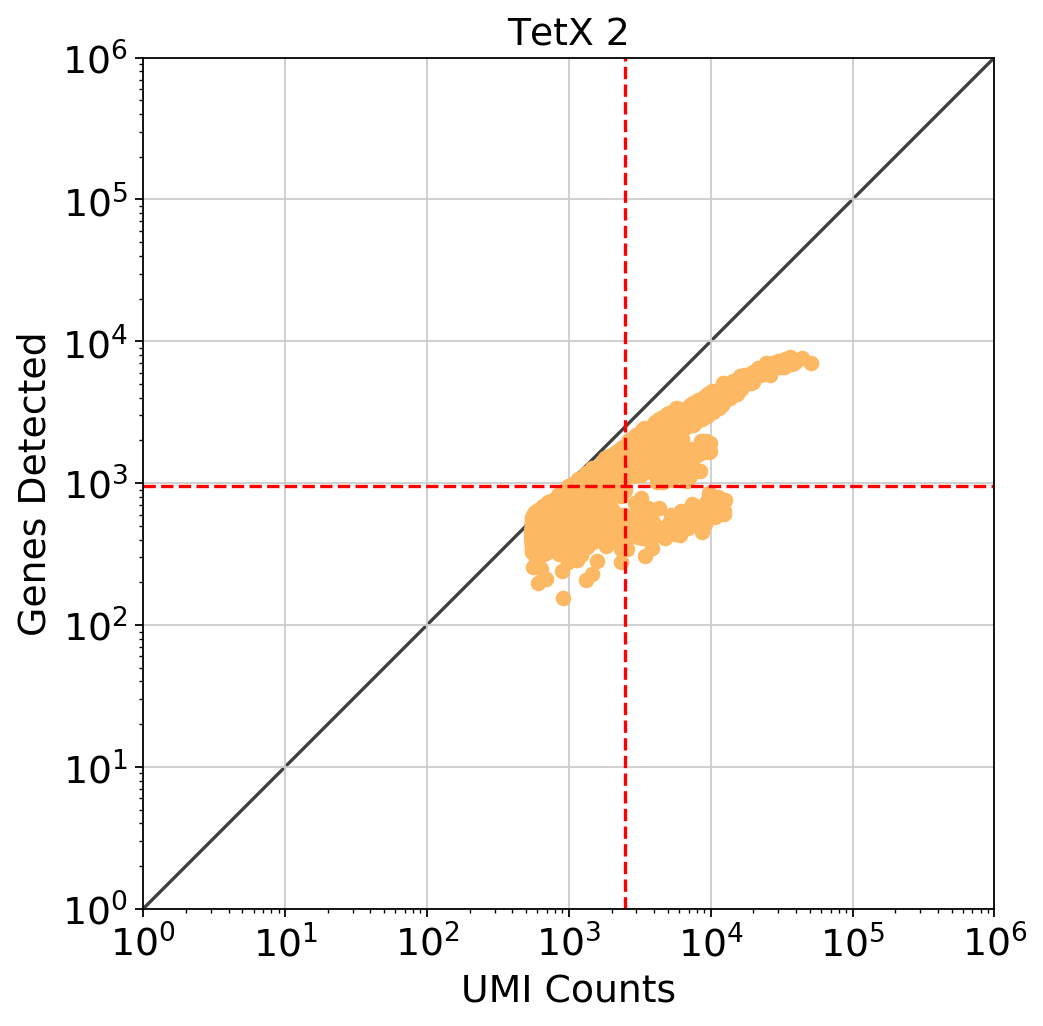

In [62]:
fig, ax = plt.subplots(figsize=(13,7))

x = np.asarray(adata_4E.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata_4E.X>0, axis=1))[:,0]

# #histogram definition
# bins = [1500, 1500] # number of bins

# # histogram the data
# hh, locx, locy = np.histogram2d(x, y, bins=bins)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
# idx = z.argsort()
# x2, y2, z2 = x[idx], y[idx], z[idx]

scatter = ax.scatter(x, y, color=colors[3])
# scatter = ax.scatter(x2, y2, c=z2, s=5, cmap='viridis')  
# fig.colorbar(scatter, ax=ax, label="Barcodes")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts", fontsize=fontsize)
ax.set_ylabel("Genes Detected", fontsize=fontsize)
ax.set_xlim(1, 10**6)
ax.set_ylim(1, 10**6)
ax.set_title(titles[3], fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)

ax.axhline(y=y_cutoff, color="r", linestyle="--")
ax.axvline(x=x_cutoff, color="r", linestyle="--")

yex(ax)
# Set grid below plot
ax.set_axisbelow(True)

fig.savefig("figures/1_library_sat_arm.png", dpi=300, format='png', bbox_inches='tight')  

fig.show()

Create masks to get the subsets of the AnnData object corresponding to the side arm and the main data:

In [63]:
arm_mask = np.logical_and(adata_4E.X.sum(axis=1)>x_cutoff, np.sum(adata_4E.X>0, axis=1)<y_cutoff)
print("Number of cells in arm: ", np.count_nonzero(arm_mask))

Number of cells in arm:  84


In [64]:
adata_4E.obs["arm"]="main"

for idx, value in enumerate(arm_mask):
    if value == True:
        adata_4E.obs["arm"][idx] = "arm"

# # This should be the right way to do this, but it does not work for some reason:
# adata_4E.obs.loc[arm_mask, "arm"] = True

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [65]:
print("Number of cells in arm: ", len(adata_4E.obs[adata_4E.obs["arm"]=="arm"]))

Number of cells in arm:  84


Find differentially expressed genes:

... storing 'species' as categorical
... storing 'batch' as categorical
... storing 'arm' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  foldchanges[global_indices]


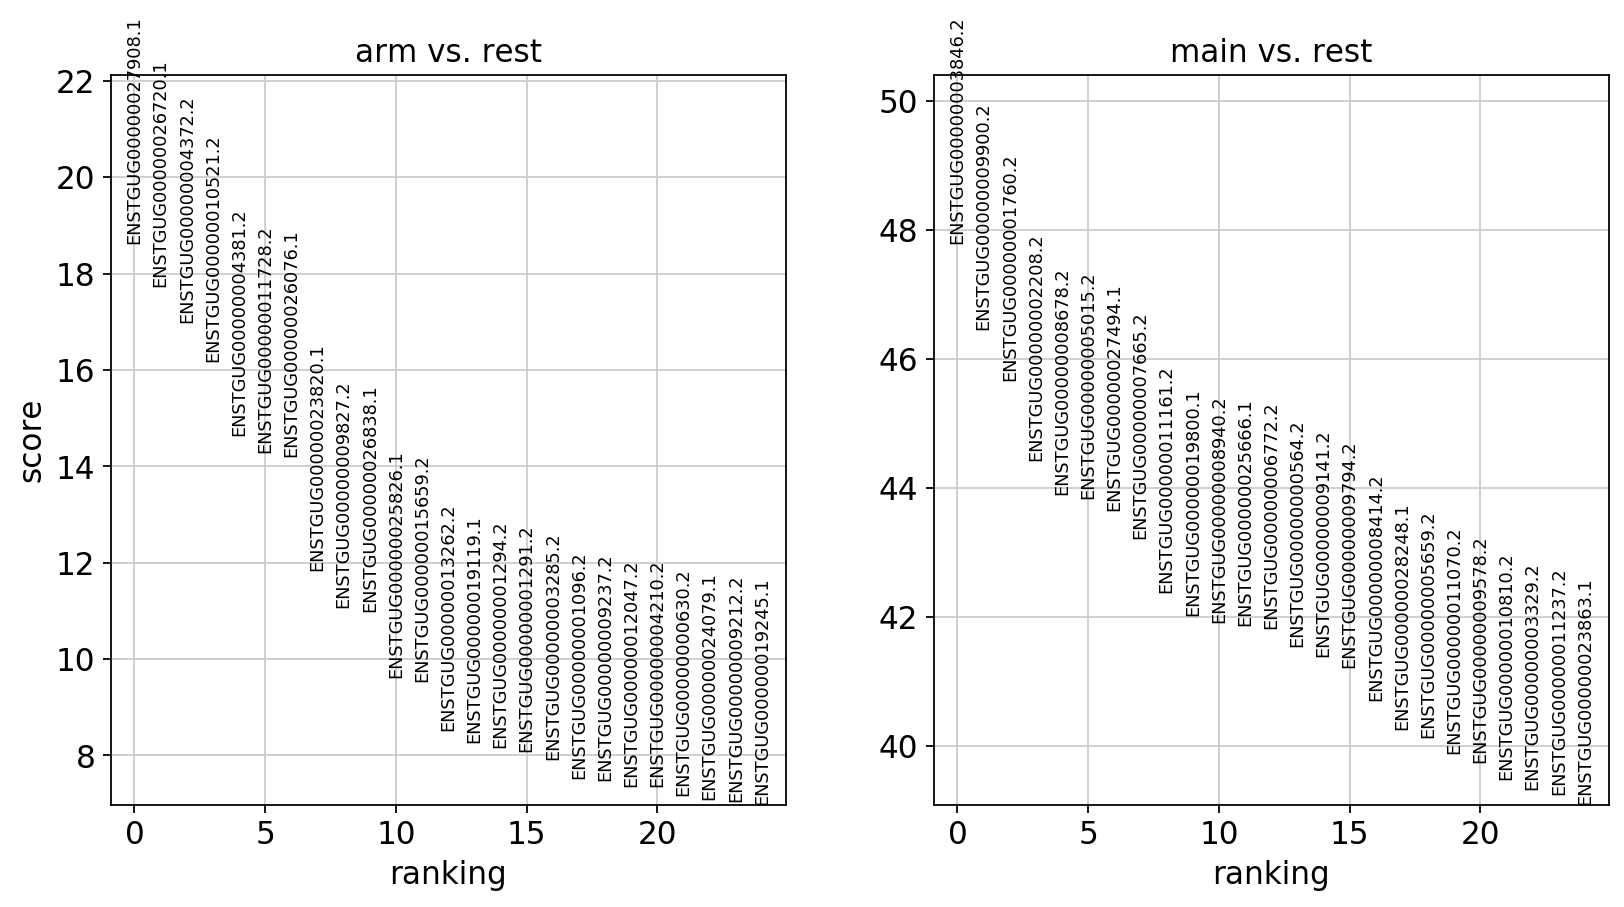

In [66]:
sc.tl.rank_genes_groups(adata_4E, groupby='arm', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_4E, n_genes=25, sharey=False, save=False)

In [67]:
arm_markers = pd.DataFrame(adata_4E.uns['rank_genes_groups']['names']).head(5)

Search for arm DE genes in Ensemble:

In [68]:
arm_markers["arm_gene_function"] = ["hemoglobin subunit rho", "novel gene", "hemoglobin alpha, subunit A (HBAA)", "histone H5", "hemoglobin alpha, subunit D (HBAD)"]
arm_markers

arm                  main  \
0  ENSTGUG00000027908.1  ENSTGUG00000003846.2   
1  ENSTGUG00000026720.1  ENSTGUG00000009900.2   
2  ENSTGUG00000004372.2  ENSTGUG00000001760.2   
3  ENSTGUG00000010521.2  ENSTGUG00000002208.2   
4  ENSTGUG00000004381.2  ENSTGUG00000008678.2   

                    arm_gene_function  
0              hemoglobin subunit rho  
1                          novel gene  
2  hemoglobin alpha, subunit A (HBAA)  
3                          histone H5  
4  hemoglobin alpha, subunit D (HBAD)

It looks like the "arm" contains red blood cells:

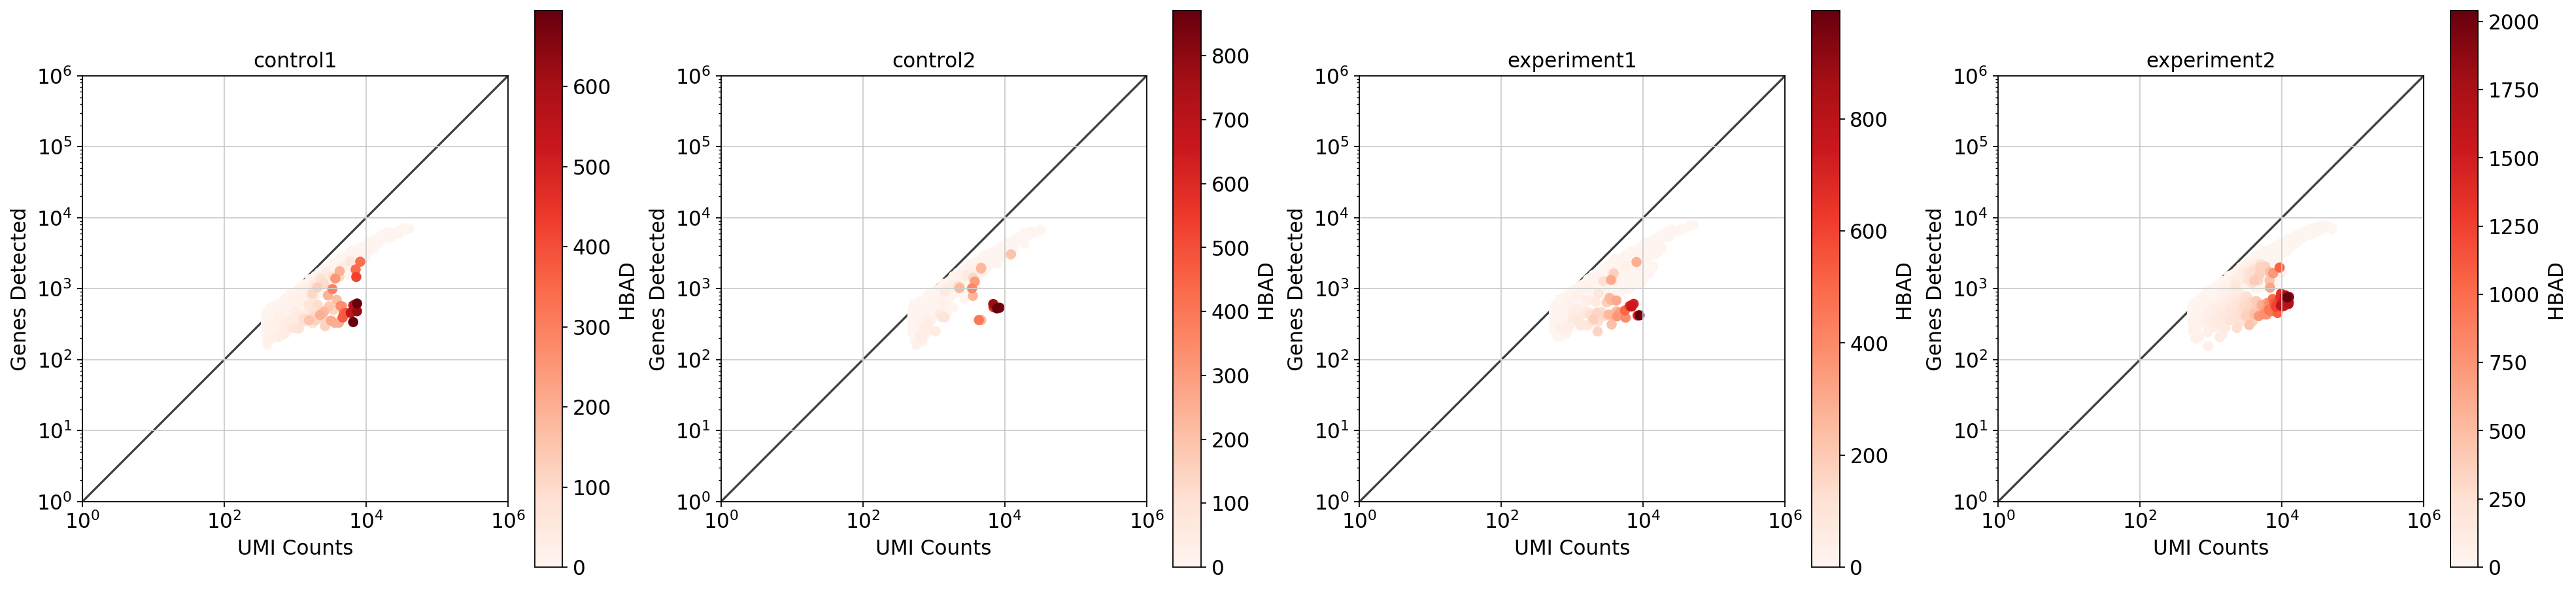

In [69]:
fig, axs = plt.subplots(figsize=(30,7), ncols=4)

for ax,adata in zip(axs, adatas):

    x = nd(adata.X.sum(1))
    y = nd((adata.X>0).sum(1))
    c = nd(adata[:, adata.var.index.str.contains("ENSTGUG00000004381.2")].X.todense())
    idx = c.argsort()
    x2, y2, c2 = x[idx], y[idx], c[idx]
    scatter = ax.scatter(x2, y2, c=c2, cmap="Reds")
    fig.colorbar(scatter, ax=ax, label="HBAD")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xlim(1, 10**6)
    ax.set_ylim(1, 10**6)
    ax.set_title("{}".format(adata.obs.batch.values[0]))
    yex(ax)
    
fig.savefig("figures/1_library_sat_HBAD.png", dpi=300, format='png', bbox_inches='tight')   

fig.show()

___

# Concatenate AnnData objects (per experiment condition)

In [20]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_control = adata_1C.concatenate(adata_2C, 
                                     join='outer', 
                                     batch_key='batch_index', 
                                     batch_categories=None, 
                                     uns_merge=None, 
                                     fill_value=np.nan)

In [21]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_experiment = adata_3E.concatenate(adata_4E, 
                                        join='outer', 
                                        batch_key='batch_index', 
                                        batch_categories=None, 
                                        uns_merge=None, 
                                        fill_value=np.nan)

In [22]:
# Add column containing sum of molecules across all genes
adata_control.obs["n_counts_raw"] = adata_control.X.sum(axis=1)
adata_experiment.obs["n_counts_raw"] = adata_experiment.X.sum(axis=1)

In [23]:
# Create new index consisting of gene_name and gene_id separated by "_" (previous index was just gene_id)
adata_control.var["gene_id"] = adata_control.var.index.values
adata_control.var.index = adata_control.var.gene_name.astype(str) + "_" + adata_control.var.gene_id.astype(str)
del adata_control.var["gene_id"]

adata_experiment.var["gene_id"] = adata_experiment.var.index.values
adata_experiment.var.index = adata_experiment.var.gene_name.astype(str) + "_" + adata_experiment.var.gene_id.astype(str)
del adata_experiment.var["gene_id"]

In [24]:
# Create copy of raw count (after basic filtering) information for scvi-tools
adata_control_scvi = adata_control.copy()
adata_experiment_scvi = adata_experiment.copy()

___

# Normalization (per experiment condition)

Show highest expressing genes before normalization:

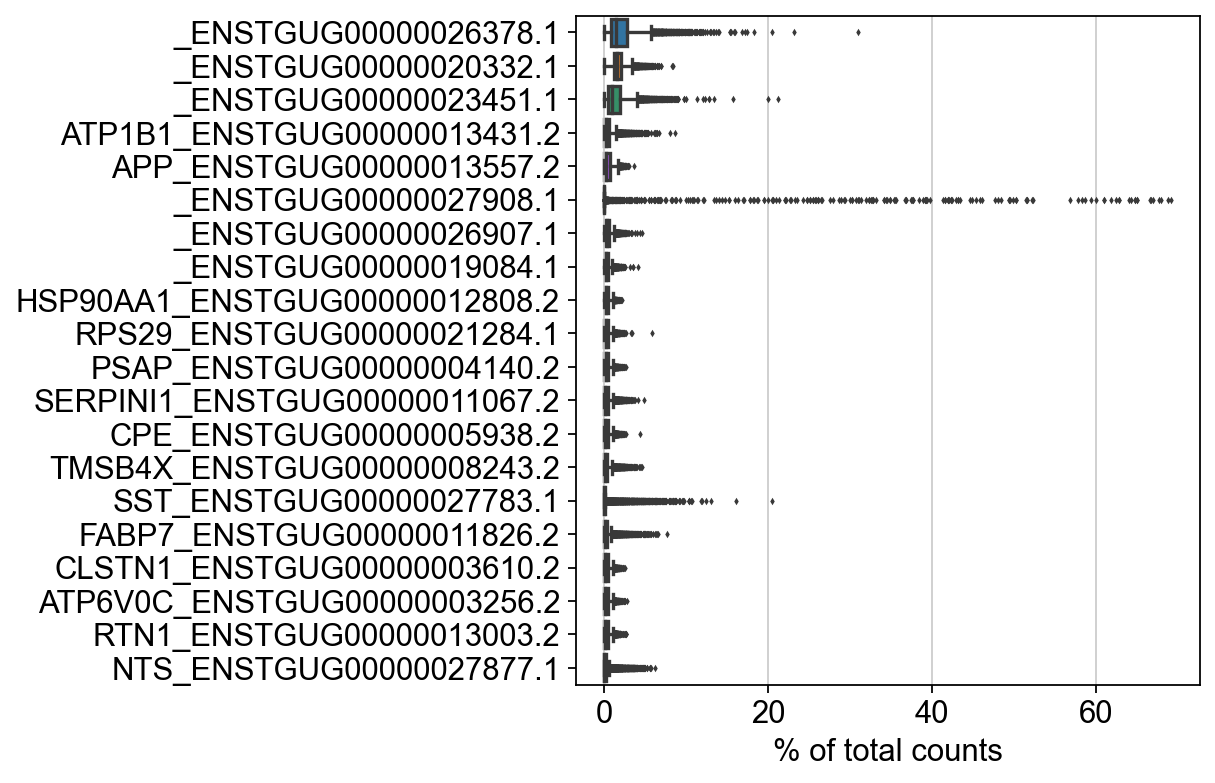

In [25]:
sc.pl.highest_expr_genes(adata_control, n_top=20, save=True)

Divide each gene count by the total # of UMI's for that cell. Then take log(X+1) (+1 because you cannot take log(0)) (=log transformation). Note: Doing CP10k instead of CPM because Leiden clustering gives ~50 clusters if I use CPM for some unkown reason.

In [26]:
adata_control.layers["raw"] = adata_control.X.copy()
sc.pp.normalize_total(adata_control, target_sum=10**4) # CP10k normalization: sum counts for each cell, divide each entry by this sum, multiply by 10k
sc.pp.log1p(adata_control) # log(expression + 1)

Highest expressed genes after normalization and log:

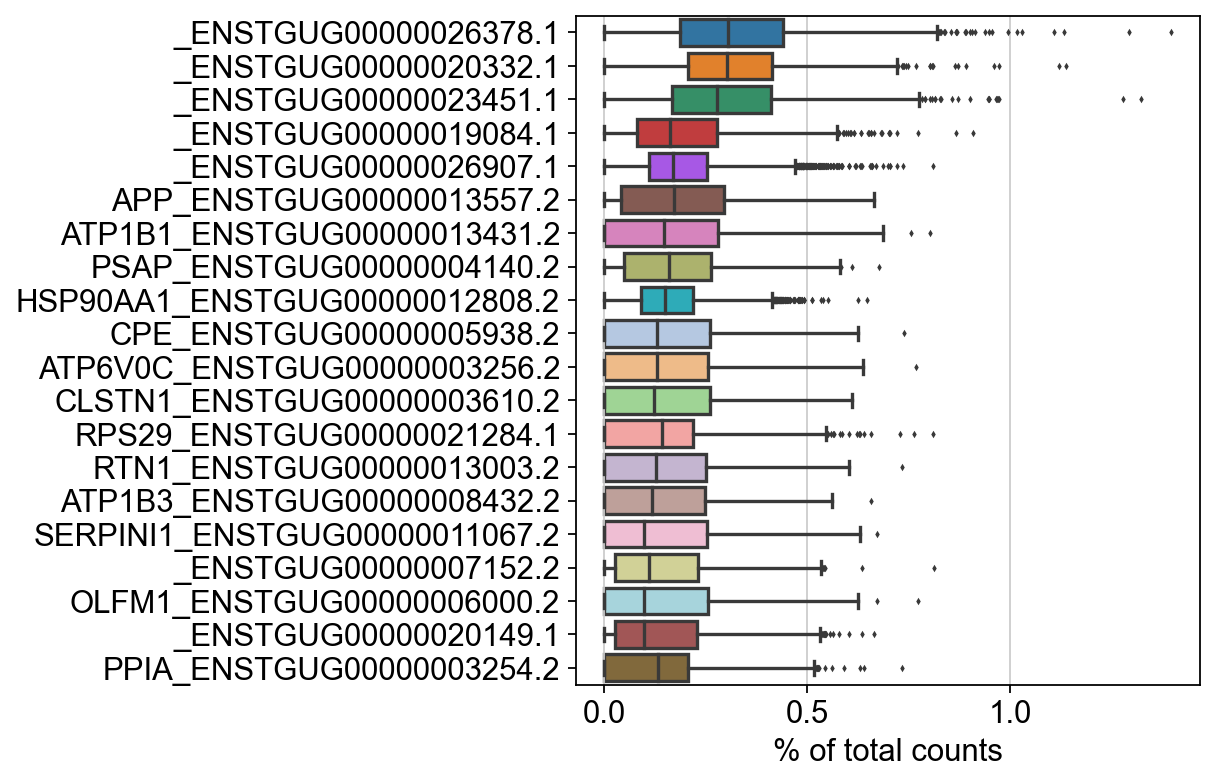

In [27]:
sc.pl.highest_expr_genes(adata_control, n_top=20)

Annotate highly variable genes:

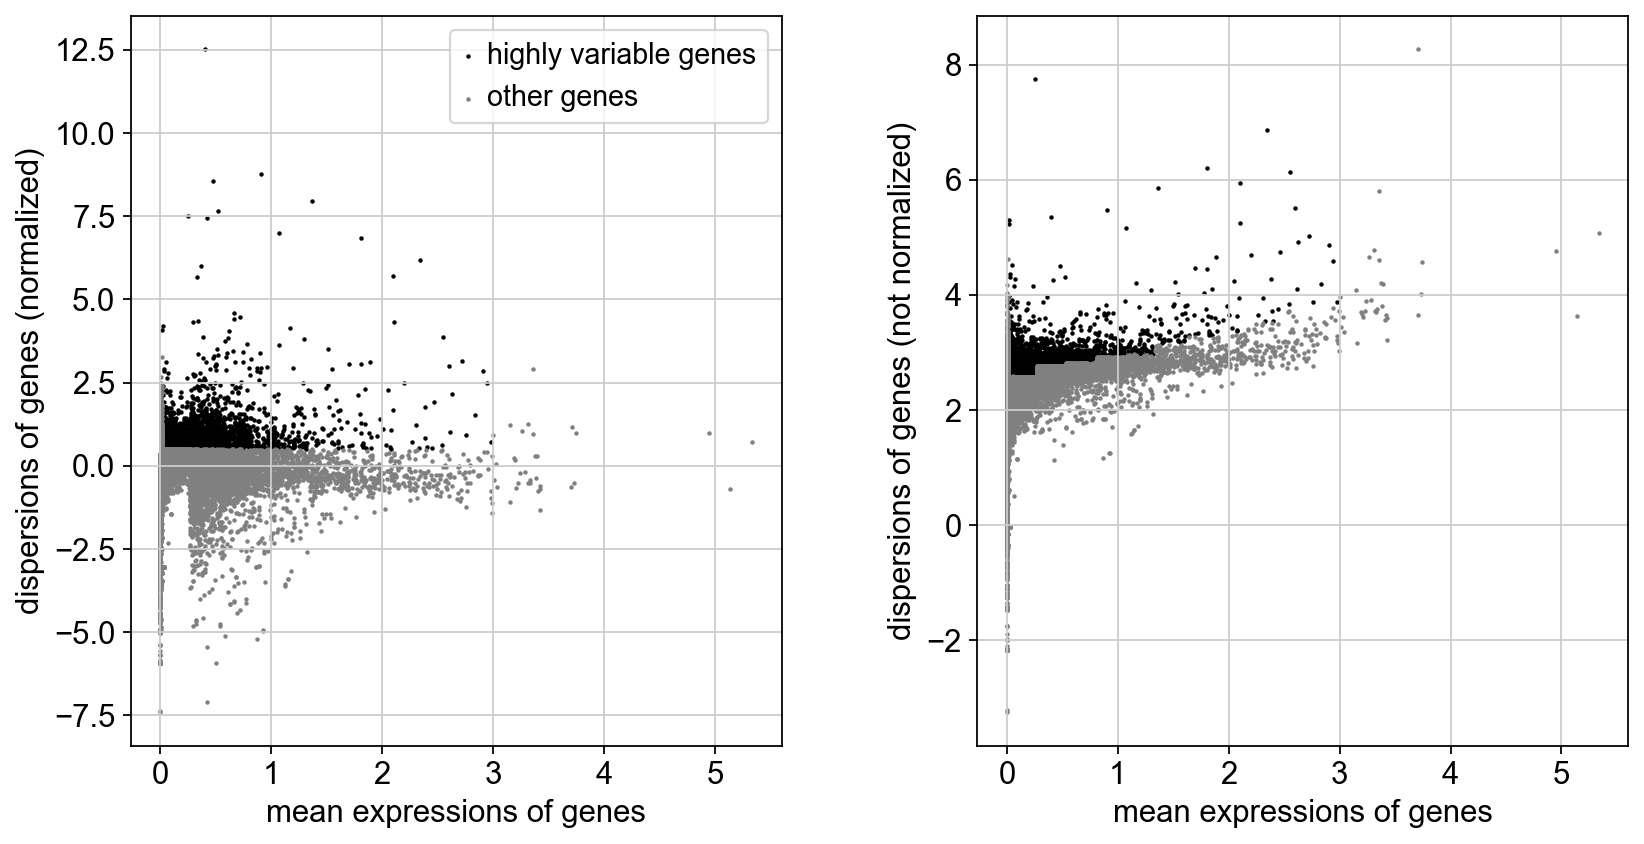

In [28]:
sc.pp.highly_variable_genes(adata_control)
sc.pl.highly_variable_genes(adata_control)

Same for experiment adata:

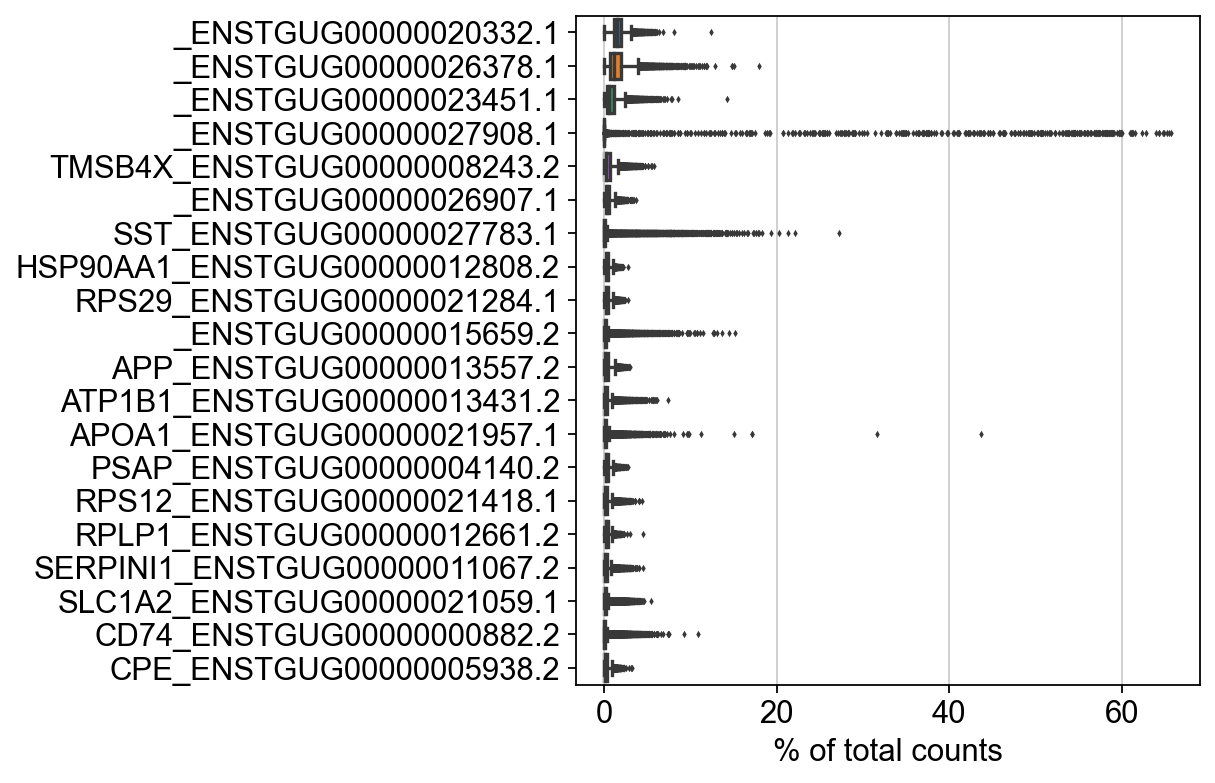

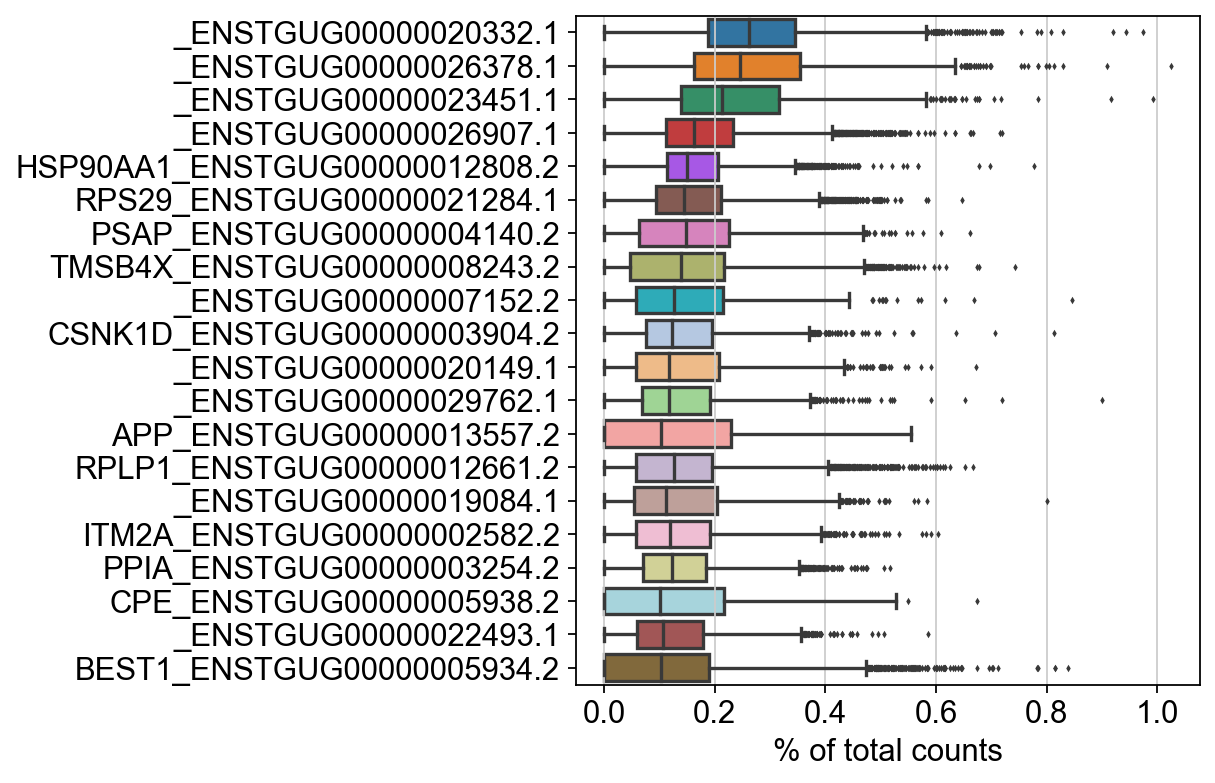

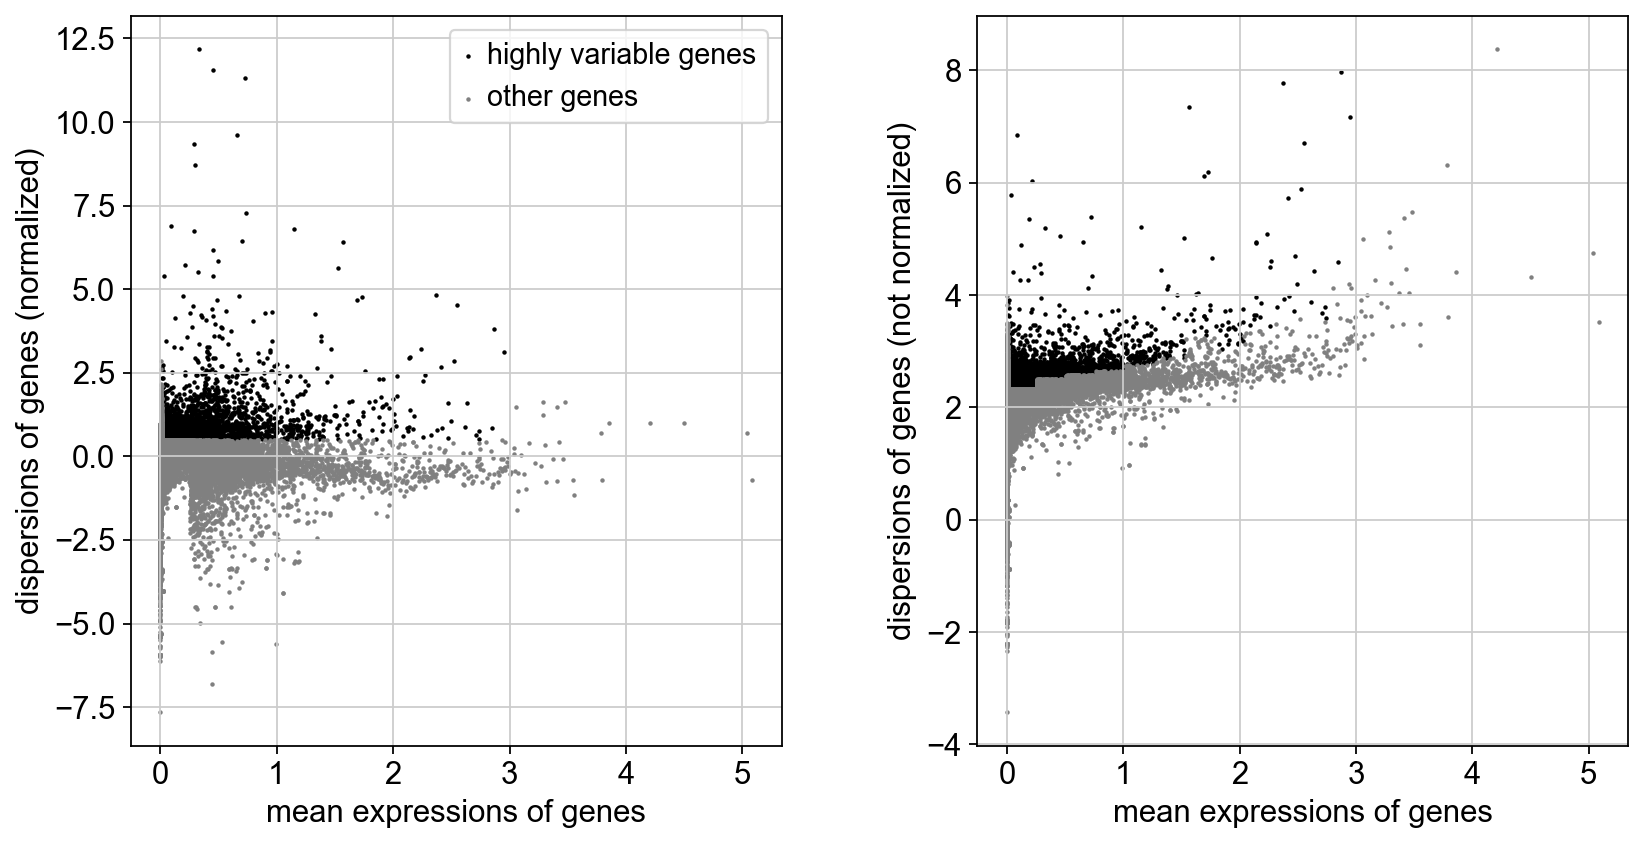

In [29]:
sc.pl.highest_expr_genes(adata_experiment, n_top=20)
adata_experiment.layers["raw"] = adata_experiment.X.copy()
sc.pp.normalize_total(adata_experiment, target_sum=10**4) # CP10k (Counts Per 10k) normalization: sum counts for each cell, divide each entry by this sum, multiply by 10k
sc.pp.log1p(adata_experiment) # log(expression + 1)
sc.pl.highest_expr_genes(adata_experiment, n_top=20)
sc.pp.highly_variable_genes(adata_experiment)
sc.pl.highly_variable_genes(adata_experiment)

___

# PCA (per experiment condition)

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [80]:
# Perform PCA on just the highly variable genes
sc.tl.pca(adata_control, use_highly_variable=True)
sc.tl.pca(adata_experiment, use_highly_variable=True)

Plot the variance ratio:

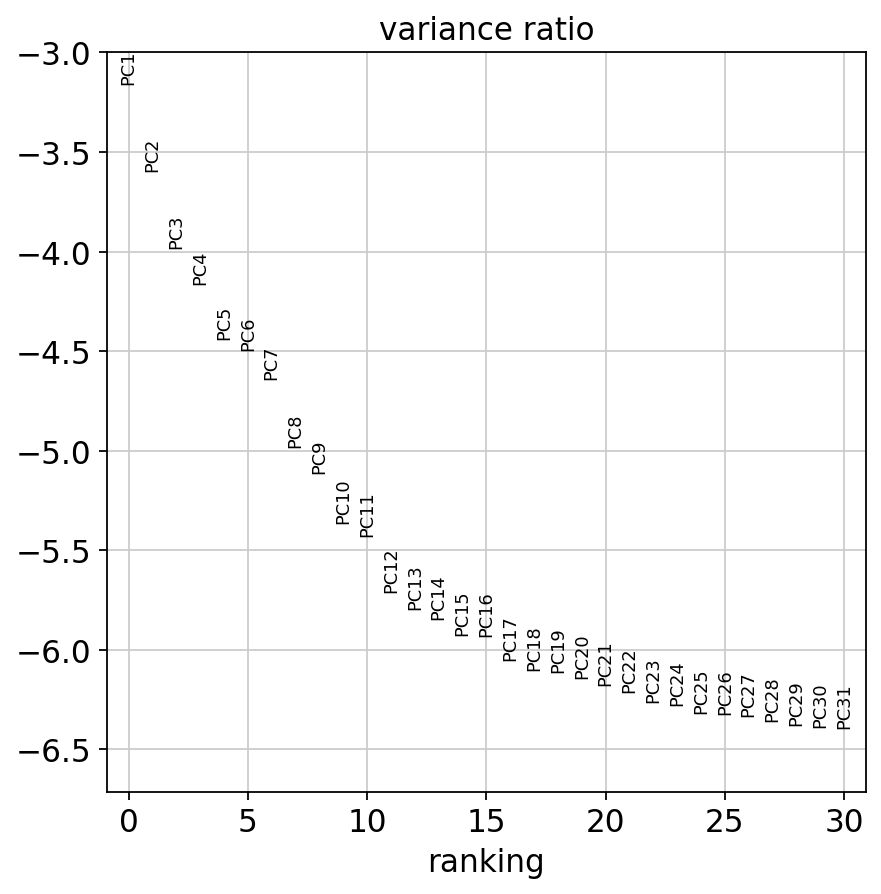

In [81]:
# Control
sc.pl.pca_variance_ratio(adata_control, log=True)

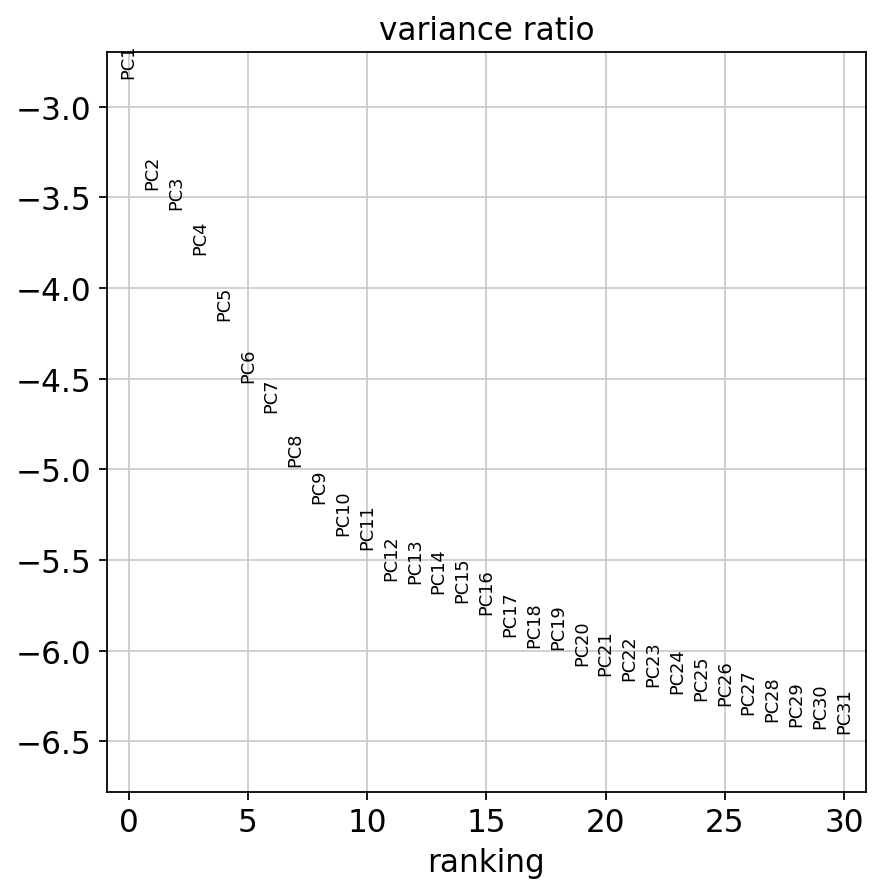

In [82]:
# Experiment
sc.pl.pca_variance_ratio(adata_experiment, log=True)

# UMAP (per experiment condition)

In [83]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 20
n_pcs=10

In [84]:
# Find nearest neighbors
sc.pp.neighbors(adata_control, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Project leiden clustering into 2D
sc.tl.umap(adata_control)

Same for experiment data:

In [85]:
# Find nearest neighbors
sc.pp.neighbors(adata_experiment, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Project leiden clustering into 2D
sc.tl.umap(adata_experiment)

# Leiden clustering (per experiment condition)

In [86]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(adata_control)
sc.tl.leiden(adata_experiment)

___

# Examine batch effects within replicates

## Controls

... storing 'species' as categorical
... storing 'batch' as categorical


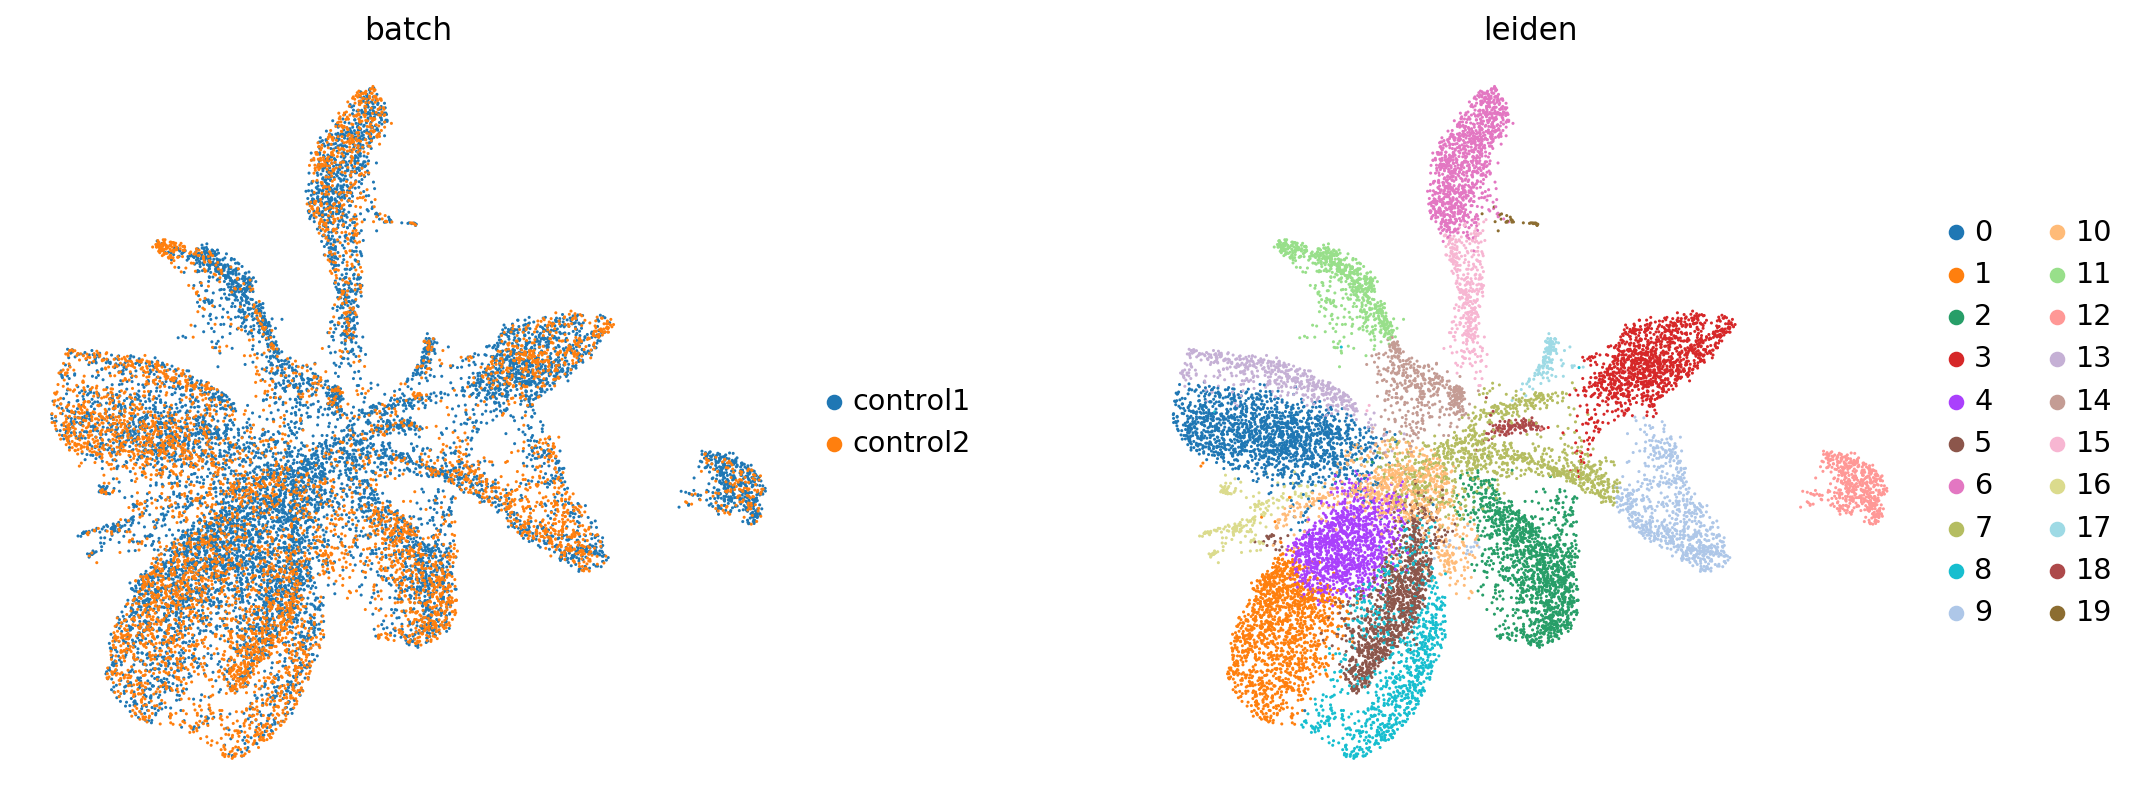

In [87]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata_control, 
           color=["batch", "leiden"],
           wspace=0.3
          )

Plot fraction of each batch per cluster (after normalizing to total cellcount in each batch):

In [88]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_control = (adata_control.obs.groupby("leiden")["batch"].value_counts() / adata_control.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_control.columns = df_control.columns.astype(str)

df_control["total normalized count"] = df_control.sum(axis=1).values

df_control["control1_fraction"] = (df_control["control1"] / df_control["total normalized count"]).values
df_control["control2_fraction"] = (df_control["control2"] / df_control["total normalized count"]).values

df_control["total number of cells"] = adata_control.obs.groupby("leiden").size().values.astype(int)

df_control.head()

batch   control1  control2  total normalized count  control1_fraction  \
leiden                                                                  
0       0.092697  0.117744                0.210441           0.440488   
1       0.077640  0.108980                0.186620           0.416034   
2       0.079689  0.104845                0.184534           0.431837   
3       0.087985  0.067968                0.155953           0.564179   
4       0.092390  0.058707                0.151096           0.611461   

batch   control2_fraction  total number of cells  
leiden                                            
0                0.559512                   1617  
1                0.583966                   1417  
2                0.568163                   1412  
3                0.435821                   1270  
4                0.388539                   1257

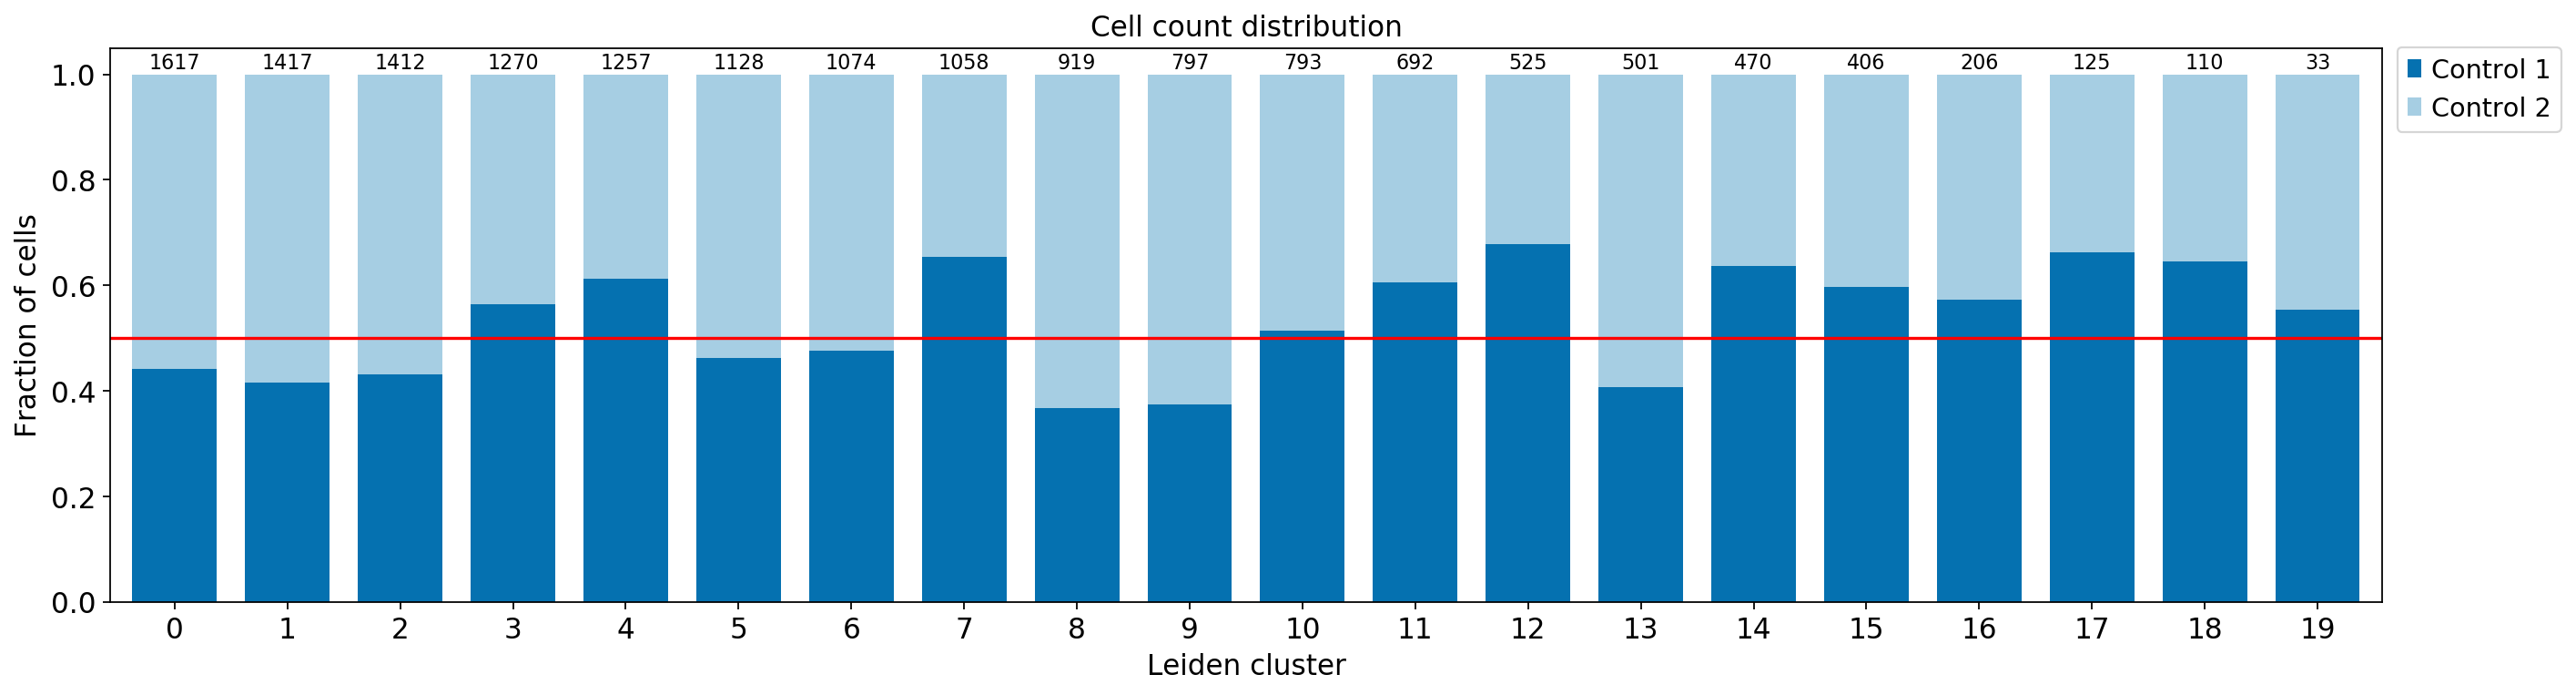

In [89]:
fig, ax = plt.subplots(figsize=(20,5))

clusters = df_control.index.values
width = 0.75

ax.bar(clusters, df_control["control1_fraction"].values, width, color=colors[0], label="Control 1")
ax.bar(clusters, df_control["control2_fraction"].values, width, bottom=df_control["control1_fraction"].values, color=colors[1], label="Control 2")

cellcounts = df_control["total number of cells"].values
# Add total cell count above each bar
for index, value in enumerate(cellcounts):
    ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

ax.set_xticklabels(clusters, rotation = 0, ha="center")
ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

ax.set(**{
    "title": "Cell count distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Leiden cluster"
})

ax.axhline(y=0.5, color='r', linestyle='-')

ax.margins(x=0.01)
ax.grid(False) 

fig.savefig("figures/1_cellcount_dist_control.png", dpi=300, format="png", bbox_inches='tight')

fig.show()

### Are there DE genes between the two control datasets?

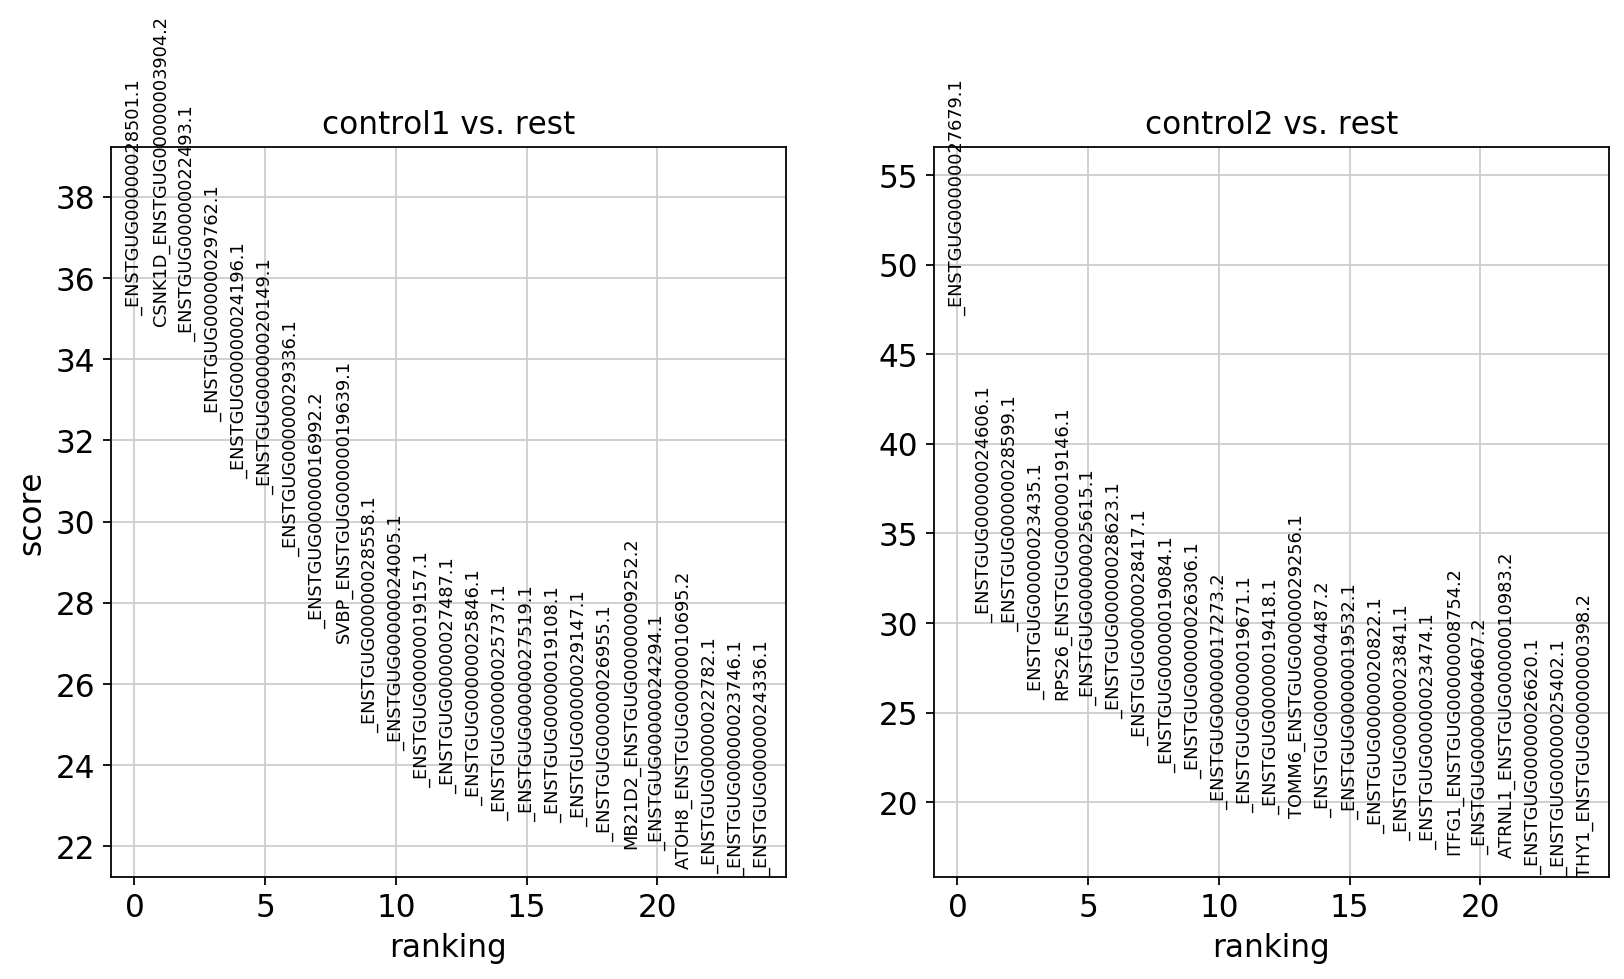

In [90]:
sc.tl.rank_genes_groups(adata_control, groupby='batch', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_control, n_genes=25, sharey=False, save=False)

In [91]:
ctrl_markers = pd.DataFrame(adata_control.uns['rank_genes_groups']['names']).head(10)
ctrl_markers

control1                    control2
0        _ENSTGUG00000028501.1       _ENSTGUG00000027679.1
1  CSNK1D_ENSTGUG00000003904.2       _ENSTGUG00000024606.1
2        _ENSTGUG00000022493.1       _ENSTGUG00000028599.1
3        _ENSTGUG00000029762.1       _ENSTGUG00000023435.1
4        _ENSTGUG00000024196.1  RPS26_ENSTGUG00000019146.1
5        _ENSTGUG00000020149.1       _ENSTGUG00000025615.1
6        _ENSTGUG00000029336.1       _ENSTGUG00000028623.1
7        _ENSTGUG00000016992.2       _ENSTGUG00000028417.1
8    SVBP_ENSTGUG00000019639.1       _ENSTGUG00000019084.1
9        _ENSTGUG00000028558.1       _ENSTGUG00000026306.1

Top 5 control 1:  
_ENSTGUG00000028501.1 novel gene  
CSNK1D_ENSTGUG00000003904.2 casein kinase 1 delta  
_ENSTGUG00000022493.1 novel gene  
_ENSTGUG00000029762.1 novel gene  
_ENSTGUG00000024196.1 novel gene  

Top 5 control 2:  
_ENSTGUG00000027679.1 ribonuclease kappa  
_ENSTGUG00000024606.1 novel gene  
_ENSTGUG00000028599.1 ribonuclease kappa   
_ENSTGUG00000023435.1 novel gene  
RPS26_ENSTGUG00000019146.1 ribosomal protein S26   

## Experiment

... storing 'species' as categorical
... storing 'batch' as categorical
... storing 'arm' as categorical


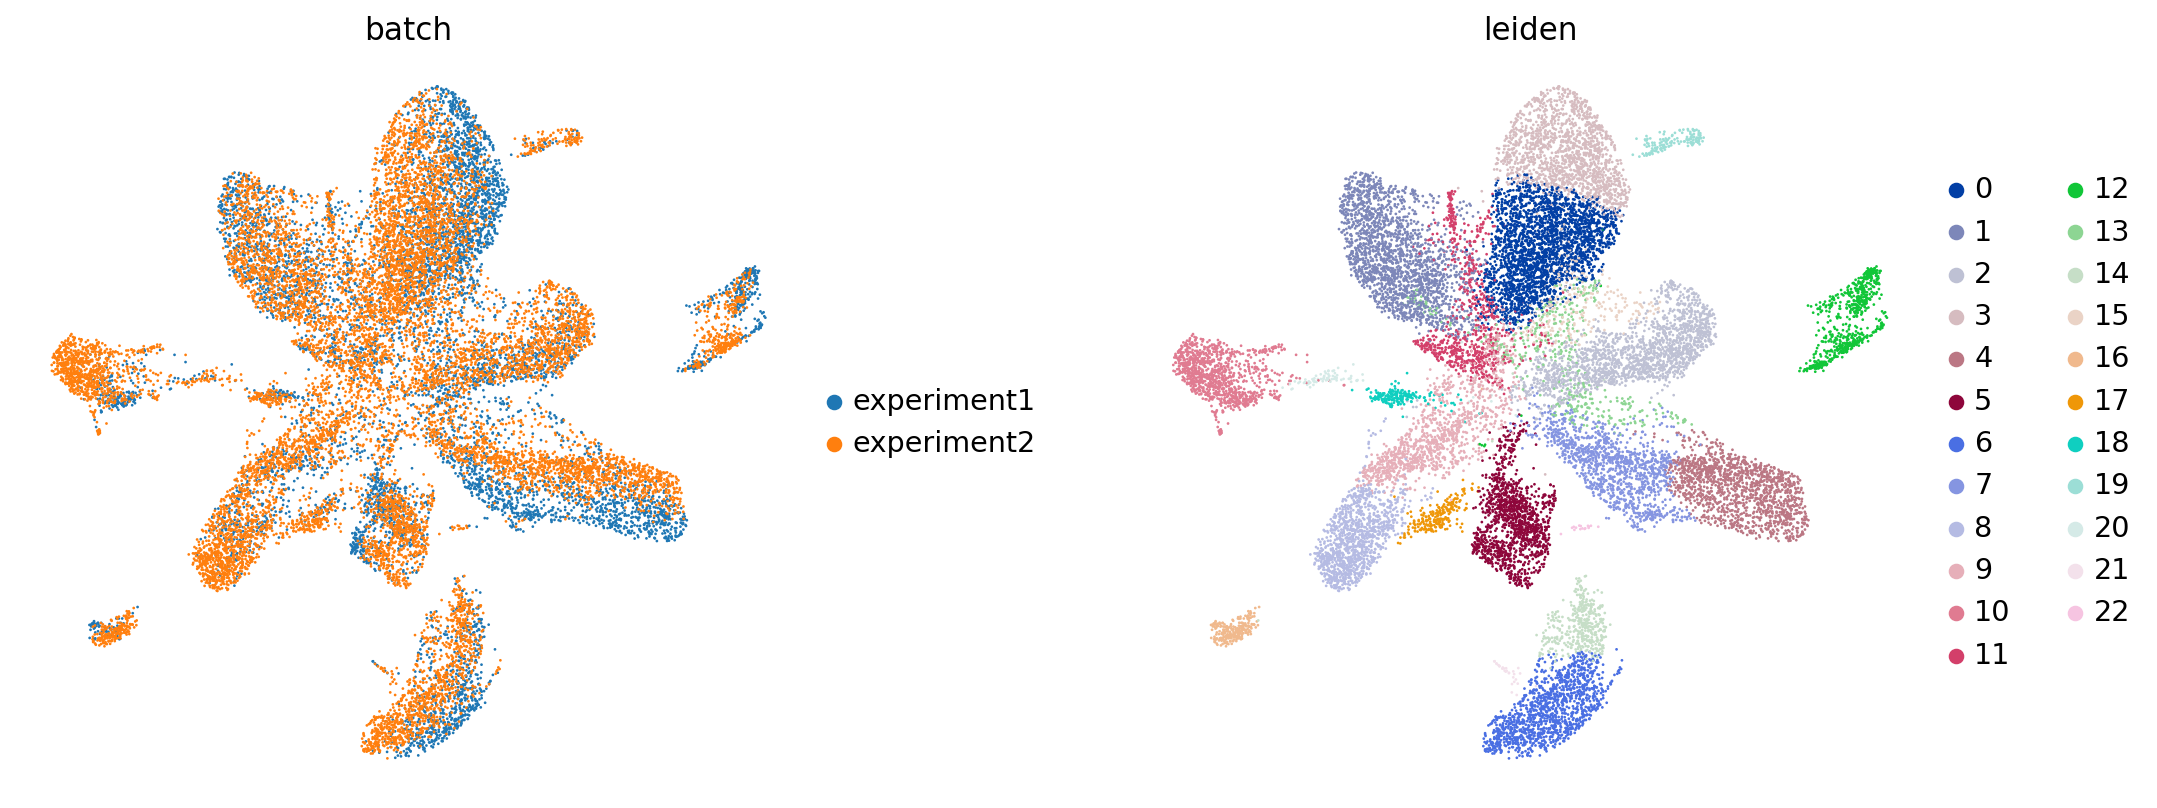

In [92]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata_experiment, 
           color=["batch", "leiden"],
           wspace=0.3
          )

In [93]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_experiment = (adata_experiment.obs.groupby("leiden")["batch"].value_counts() / adata_experiment.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_experiment.columns = df_experiment.columns.astype(str)

df_experiment["total normalized count"] = df_experiment.sum(axis=1).values

df_experiment["experiment1_fraction"] = (df_experiment["experiment1"] / df_experiment["total normalized count"]).values
df_experiment["experiment2_fraction"] = (df_experiment["experiment2"] / df_experiment["total normalized count"]).values

df_experiment["total number of cells"] = adata_experiment.obs.groupby("leiden").size().values.astype(int)

df_experiment.head()

batch   experiment1  experiment2  total normalized count  \
leiden                                                     
0          0.136906     0.128662                0.265568   
1          0.110174     0.094320                0.204494   
2          0.079808     0.093913                0.173721   
3          0.115235     0.052409                0.167644   
4          0.084480     0.062174                0.146654   

batch   experiment1_fraction  experiment2_fraction  total number of cells  
leiden                                                                     
0                   0.515522              0.484478                   2636  
1                   0.538765              0.461235                   2008  
2                   0.459404              0.540596                   1769  
3                   0.687380              0.312620                   1532  
4                   0.576047              0.423953                   1415

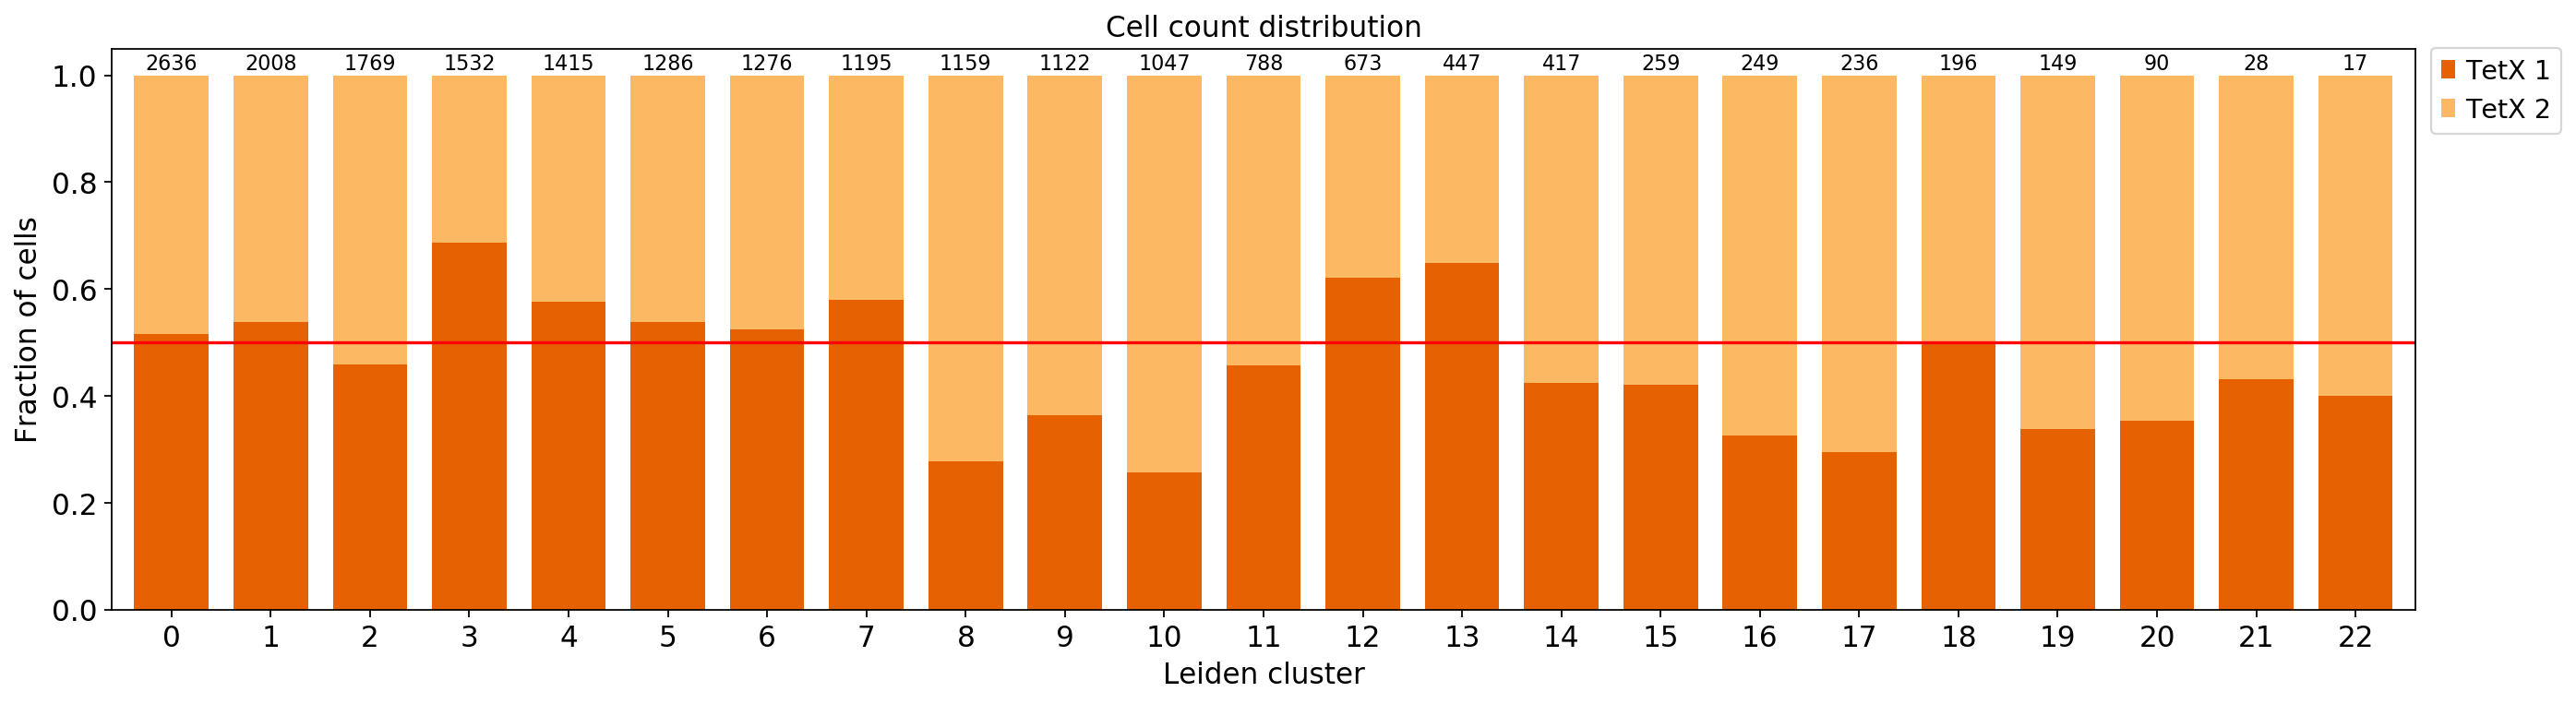

In [94]:
fig, ax = plt.subplots(figsize=(20,5))

clusters = df_experiment.index.values
width = 0.75

ax.bar(clusters, df_experiment["experiment1_fraction"].values, width, color=colors[2], label="TetX 1")
ax.bar(clusters, df_experiment["experiment2_fraction"].values, width, bottom=df_experiment["experiment1_fraction"].values, color=colors[3], label="TetX 2")

cellcounts = df_experiment["total number of cells"].values
# Add total cell count above each bar
for index, value in enumerate(cellcounts):
    ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

ax.set_xticklabels(clusters, rotation = 0, ha="center")
ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

ax.set(**{
    "title": "Cell count distribution",
    "ylabel": "Fraction of cells",
    "xlabel": "Leiden cluster"
})

ax.axhline(y=0.5, color='r', linestyle='-')

ax.margins(x=0.01)
ax.grid(False) 

fig.savefig("figures/1_cellcount_dist_tetx.png", dpi=300, format="png", bbox_inches='tight')

fig.show()

The batch effect seems to be a little worse for the experiment batches, but for both conditions each cell type includes cells from all replicates which is good. As expected, control1 and experiment2 are overrepresented due to a higher total cellcount.

### Are there DE genes between the two experiment batches?

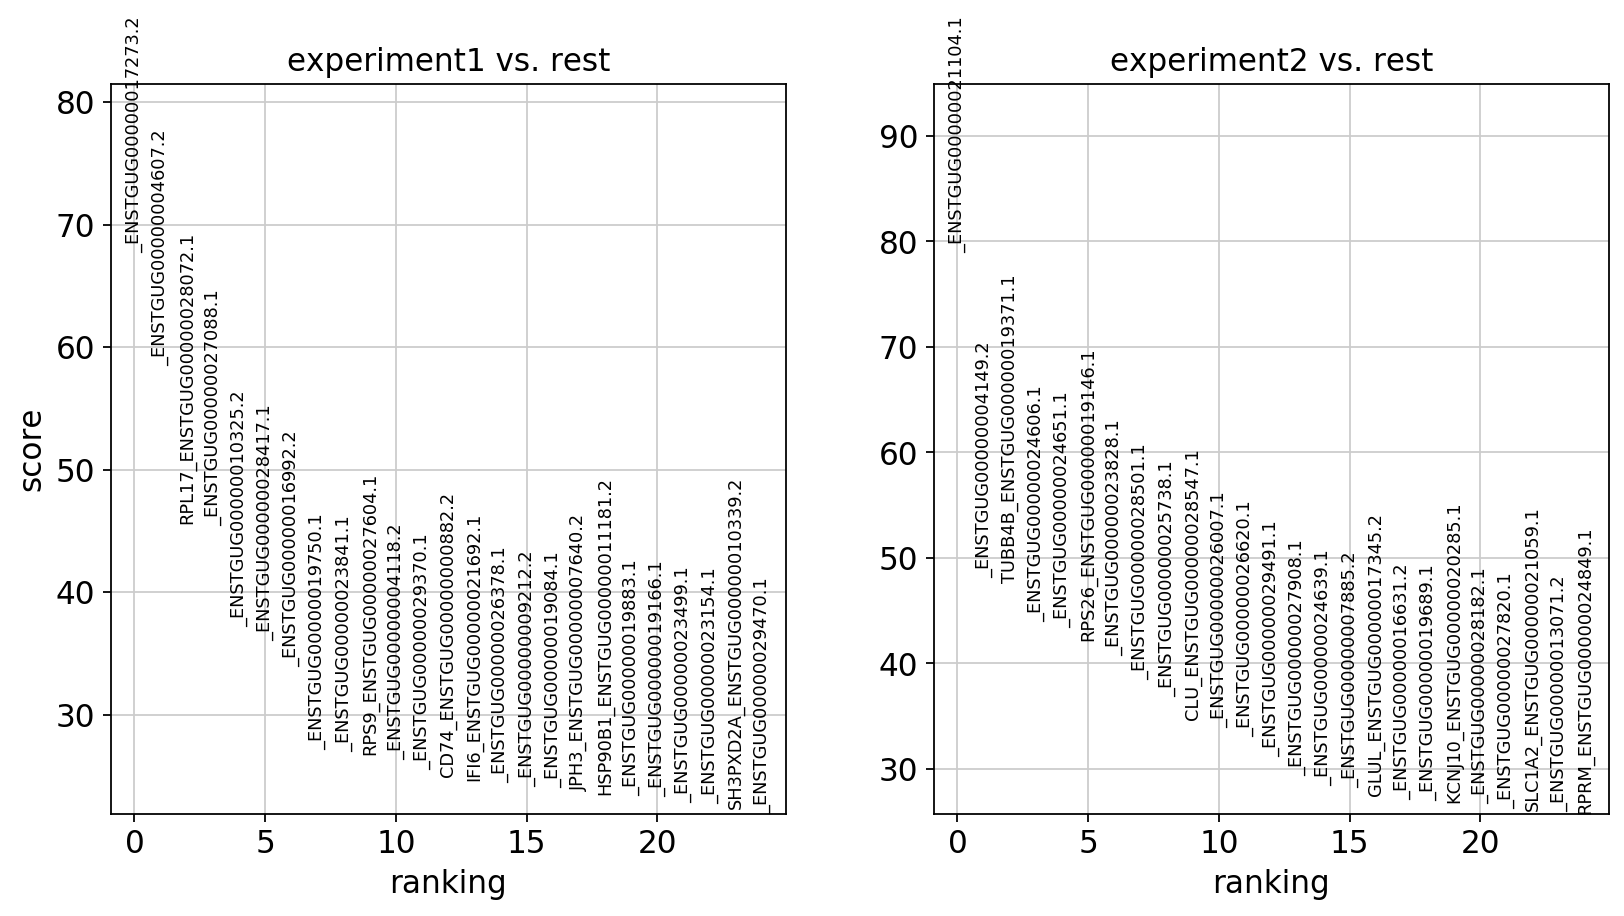

In [95]:
sc.tl.rank_genes_groups(adata_experiment, groupby='batch', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_experiment, n_genes=25, sharey=False, save=False)

In [96]:
exp_markers = pd.DataFrame(adata_experiment.uns['rank_genes_groups']['names']).head(10)
exp_markers

experiment1                  experiment2
0       _ENSTGUG00000017273.2        _ENSTGUG00000021104.1
1       _ENSTGUG00000004607.2        _ENSTGUG00000004149.2
2  RPL17_ENSTGUG00000028072.1  TUBB4B_ENSTGUG00000019371.1
3       _ENSTGUG00000027088.1        _ENSTGUG00000024606.1
4       _ENSTGUG00000010325.2        _ENSTGUG00000024651.1
5       _ENSTGUG00000028417.1   RPS26_ENSTGUG00000019146.1
6       _ENSTGUG00000016992.2        _ENSTGUG00000023828.1
7       _ENSTGUG00000019750.1        _ENSTGUG00000028501.1
8       _ENSTGUG00000023841.1        _ENSTGUG00000025738.1
9   RPS9_ENSTGUG00000027604.1     CLU_ENSTGUG00000028547.1

Top 5 DE genes in exp 1:  
_ENSTGUG00000017273.2 novel gene  
_ENSTGUG00000004607.2 novel gene  
RPL17_ENSTGUG00000028072.1 ribosomal protein L17  
_ENSTGUG00000027088.1 novel gene  
_ENSTGUG00000010325.2 novel gene  

Top 5 DE genes in exp 2:  
_ENSTGUG00000021104.1 novel gene  
_ENSTGUG00000004149.2 small nuclear ribonucleoprotein G  
TUBB4B_ENSTGUG00000019371.1 tubulin beta-4B chain  
_ENSTGUG00000024606.1 novel gene  
_ENSTGUG00000024651.1 novel gene  

___

# Within replicate batch correction with scvi

### Batch correction of control replicates with scvi

Use adata_control_scvi (instead of adata_control), because scvi takes unnormalized counts. Set up and train model:

In [97]:
scvi.data.setup_anndata(adata_control_scvi, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 15810 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [98]:
# model_ctrl = scvi.model.SCVI(adata_control_scvi)
# model_ctrl.train()
# model_ctrl.save("control_scvi", overwrite=False)

In [99]:
# Load existing model
model_ctrl = scvi.model.SCVI.load("control_scvi", adata_control_scvi)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15810 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Store the outputs of scvi-tools back into the original anndata to permit interoperability with Scanpy:

In [100]:
adata_control_scvi.obsm["X_scvi"] = model_ctrl.get_latent_representation()
adata_control_scvi.layers["scvi_expr"] = model_ctrl.get_normalized_expression(adata_control_scvi, n_samples=5, return_mean=True)
adata_control_scvi.layers["scvi_normalized"] = model_ctrl.get_normalized_expression(library_size=10e4)

#### Exploratory analysis of batch effect within controls after scvi correction

In [101]:
sc.pp.neighbors(adata_control_scvi, use_rep="X_scvi", metric="correlation")
sc.tl.leiden(adata_control_scvi, key_added="leiden_scvi", resolution=1.2)
sc.tl.umap(adata_control_scvi, min_dist=0.4)

In [102]:
adata_control_scvi

AnnData object with n_obs × n_vars = 15810 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi'
    var: 'gene_name'
    uns: '_scvi', 'neighbors', 'leiden', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'scvi_expr', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

... storing 'species' as categorical
... storing 'batch' as categorical


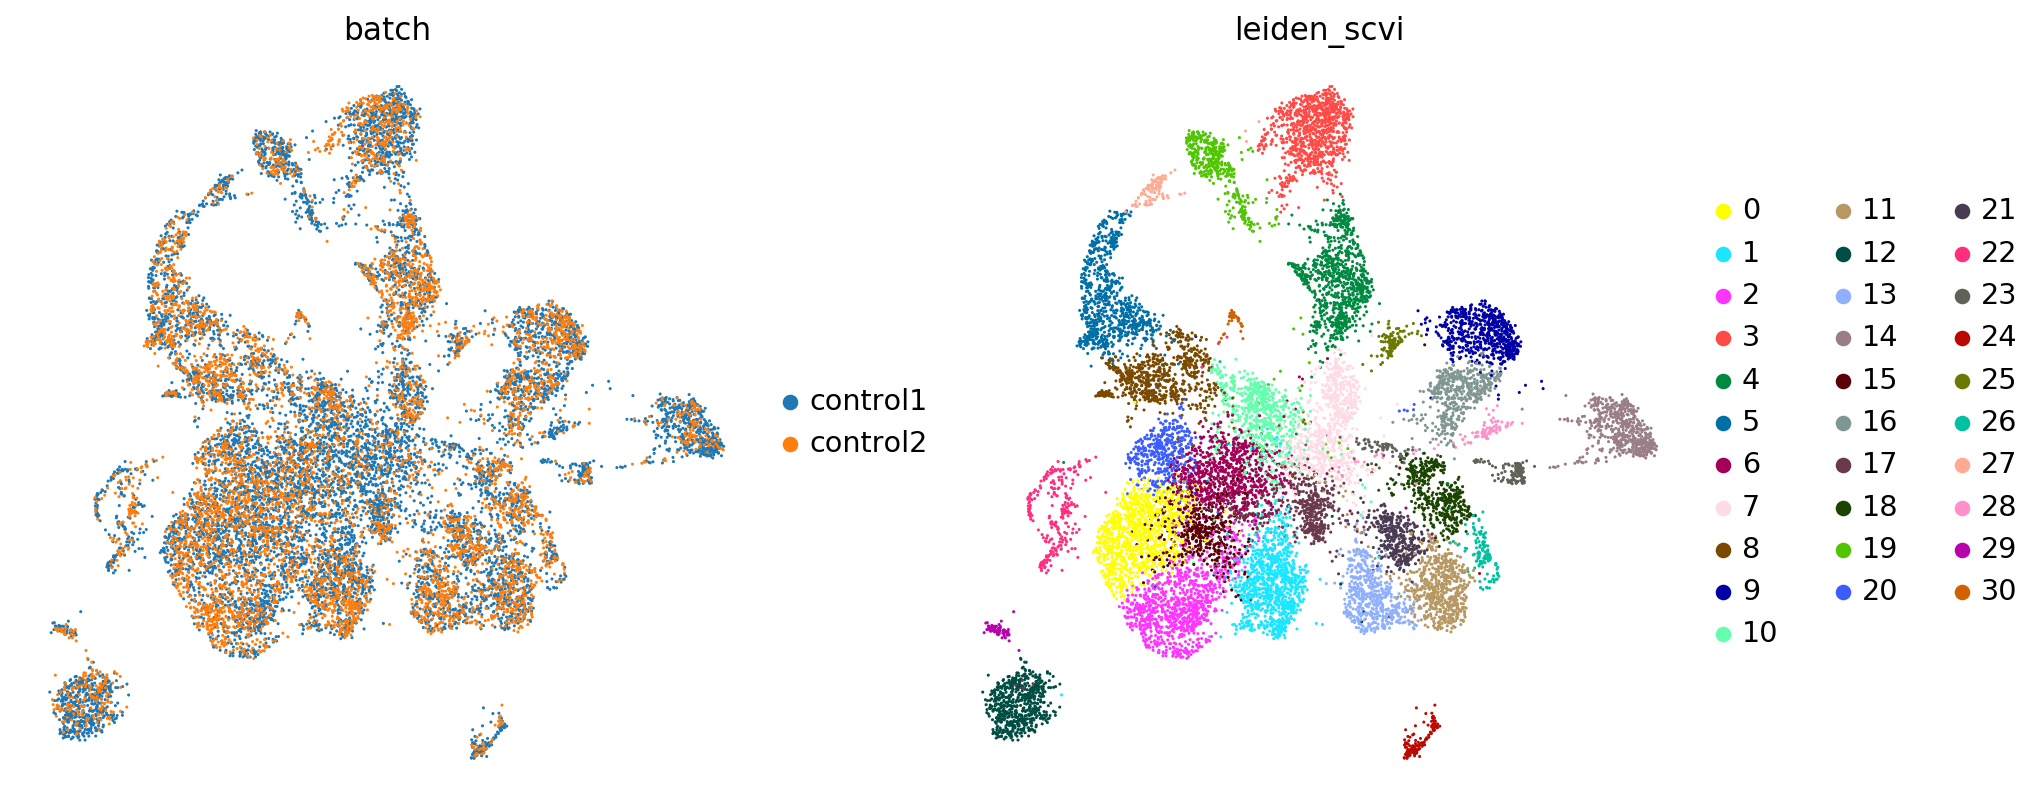

In [103]:
sc.pl.umap(
    adata_control_scvi,
    color=["batch", "leiden_scvi"],
    frameon=False,
    ncols=2
)

In [104]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_control_2 = (adata_control_scvi.obs.groupby("leiden_scvi")["batch"].value_counts() / adata_control_scvi.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_control_2.columns = df_control_2.columns.astype(str)

df_control_2["total normalized count"] = df_control_2.sum(axis=1).values

df_control_2["control1_fraction"] = (df_control_2["control1"] / df_control_2["total normalized count"]).values
df_control_2["control2_fraction"] = (df_control_2["control2"] / df_control_2["total normalized count"]).values

df_control_2["total number of cells"] = adata_control_scvi.obs.groupby("leiden_scvi").size().values.astype(int)

df_control_2.head()

batch        control1  control2  total normalized count  control1_fraction  \
leiden_scvi                                                                  
0            0.062686  0.079047                0.141733           0.442280   
1            0.057974  0.068629                0.126603           0.457919   
2            0.052238  0.073425                0.125663           0.415700   
3            0.059613  0.054738                0.114351           0.521316   
4            0.046502  0.075079                0.121581           0.382479   

batch        control2_fraction  total number of cells  
leiden_scvi                                            
0                     0.557720                   1090  
1                     0.542081                    981  
2                     0.584300                    954  
3                     0.478684                    913  
4                     0.617521                    908

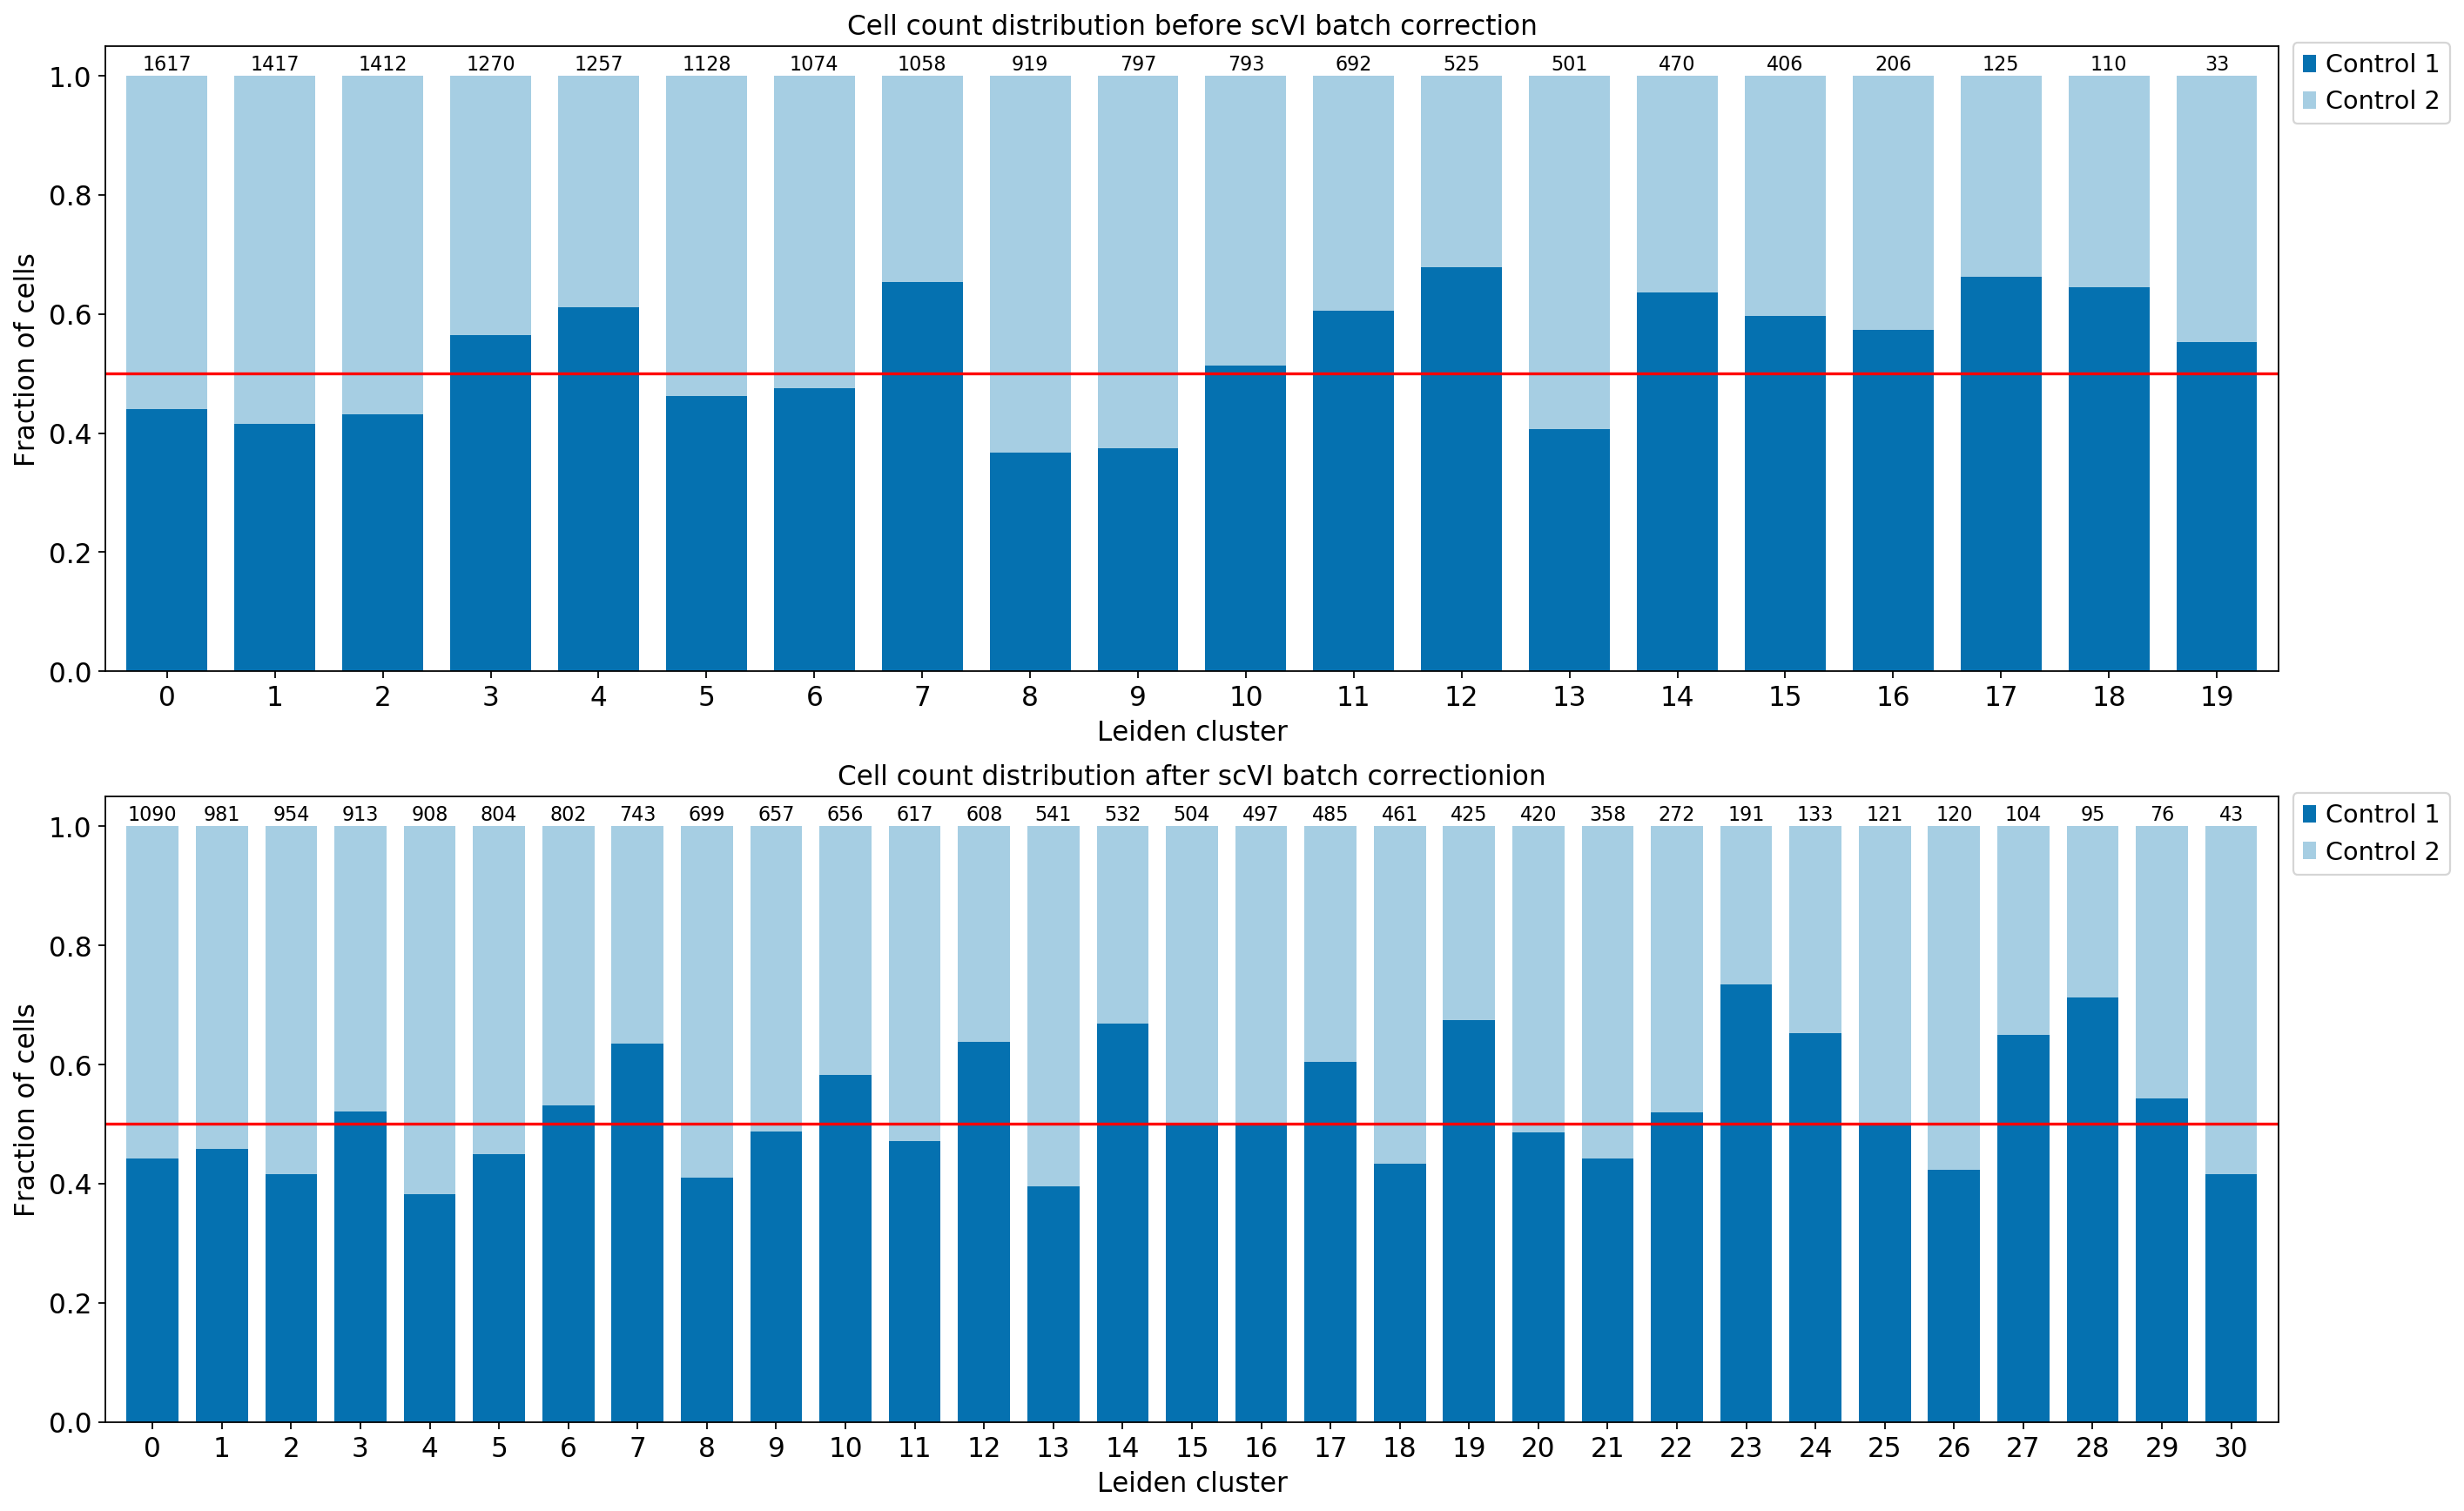

In [105]:
fig, axs = plt.subplots(figsize=(20,13), nrows=2)

dfs = [df_control, df_control_2]
titles = ["before scVI batch correction", "after scVI batch correctionion"]
i=0

for ax,df in zip(axs, dfs):
    clusters = df.index.values
    width = 0.75

    ax.bar(clusters, df["control1_fraction"].values, width, color=colors[0], label="Control 1")
    ax.bar(clusters, df["control2_fraction"].values, width, bottom=df["control1_fraction"].values, color=colors[1], label="Control 2")
    
    cellcounts = df["total number of cells"].values
    # Add total cell count above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

    ax.set_xticklabels(clusters, rotation = 0, ha="center")
    ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

    ax.set(**{
        "title": "Cell count distribution {}".format(titles[i]),
        "ylabel": "Fraction of cells",
        "xlabel": "Leiden cluster"
    })
    
    i+=1

    ax.axhline(y=0.5, color='r', linestyle='-')

    ax.margins(x=0.01)
    ax.grid(False)
    
fig.savefig("figures/1_cellcount_scvi_control.png", dpi=300, format="png", bbox_inches='tight')

fig.show()

### Batch correction of experiment replicates with scvi:

In [106]:
scvi.data.setup_anndata(adata_experiment_scvi, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 19994 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [107]:
# model_exp = scvi.model.SCVI(adata_experiment_scvi)
# model_exp.train()
# model_exp.save("experiment_scvi", overwrite=False)

In [108]:
# Load existing model
model_exp = scvi.model.SCVI.load("experiment_scvi", adata_experiment_scvi)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 19994 cells, 22151 vars, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Store the outputs of scvi-tools back into the original anndata to permit interoperability with Scanpy:

In [109]:
adata_experiment_scvi.obsm["X_scvi"] = model_exp.get_latent_representation()
adata_experiment_scvi.layers["scvi_expr"] = model_exp.get_normalized_expression(adata_experiment_scvi, n_samples=5, return_mean=True)
adata_experiment_scvi.layers["scvi_normalized"] = model_exp.get_normalized_expression(library_size=10e4)

#### Exploratory analysis of batch effect within experiment batches after scvi correction

In [110]:
sc.pp.neighbors(adata_experiment_scvi, use_rep="X_scvi", metric="correlation")
sc.tl.leiden(adata_experiment_scvi, key_added="leiden_scvi", resolution=1.2)
sc.tl.umap(adata_experiment_scvi, min_dist=0.4)

... storing 'species' as categorical
... storing 'batch' as categorical
... storing 'arm' as categorical


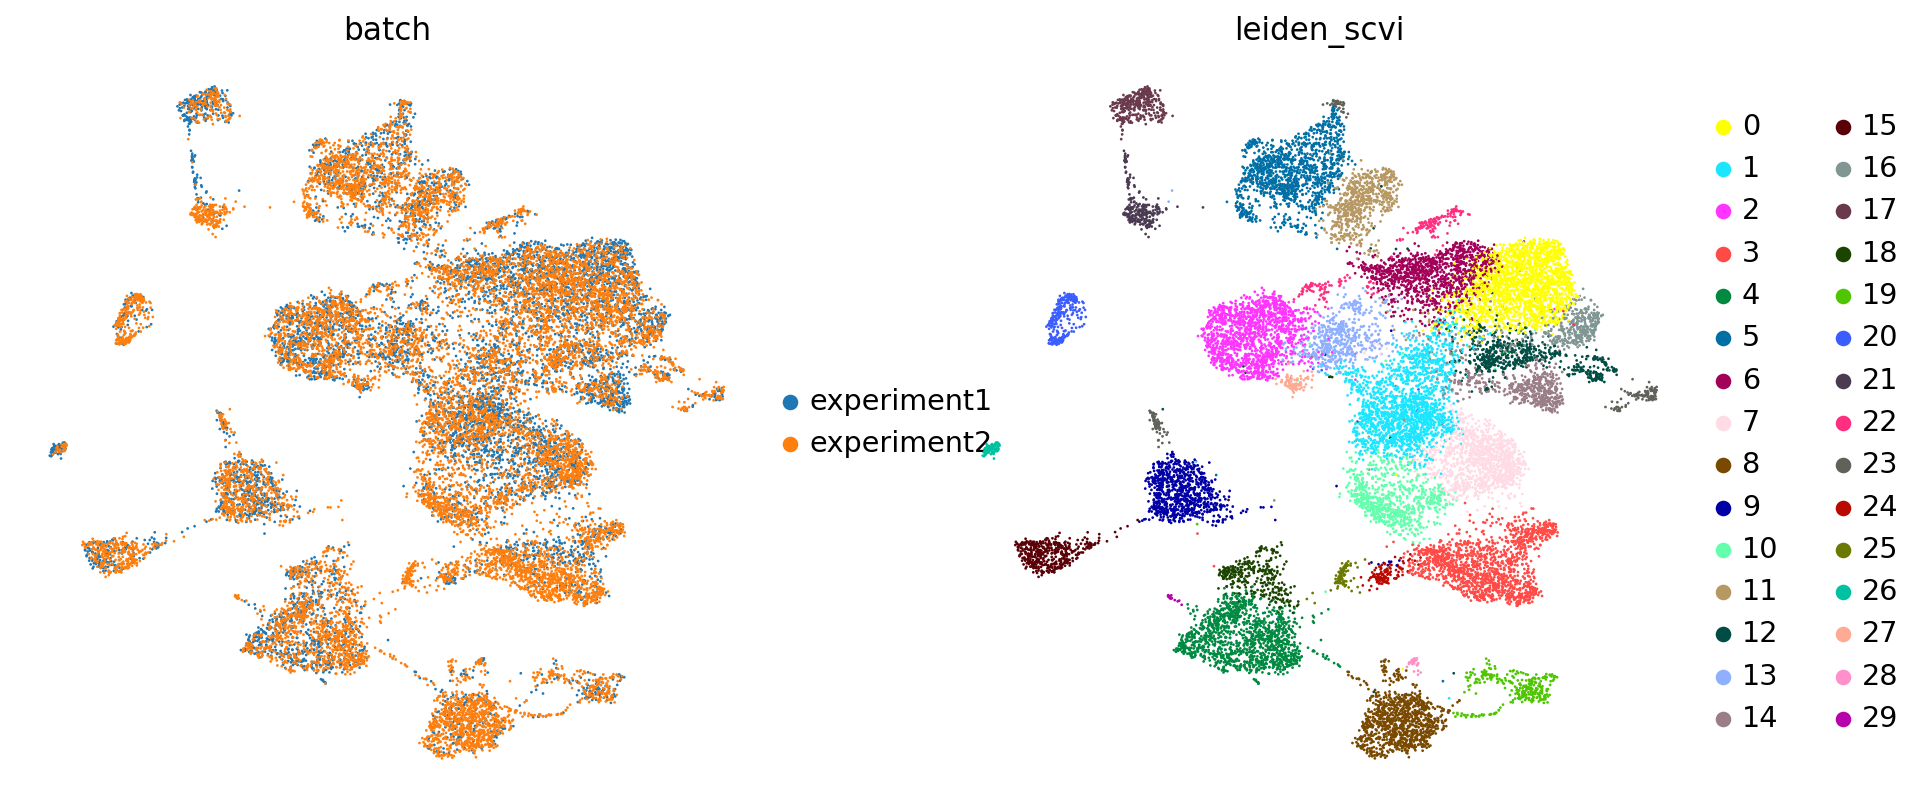

In [111]:
sc.pl.umap(
    adata_experiment_scvi,
    color=["batch", "leiden_scvi"],
    frameon=False,
    ncols=2
)

In [112]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_experiment_2 = (adata_experiment_scvi.obs.groupby("leiden_scvi")["batch"].value_counts() / adata_experiment_scvi.obs.groupby("batch")["species"].count()).unstack().fillna(0)
# The above returns a categorical dataframe, so we will convert the columns to strings
df_experiment_2.columns = df_experiment_2.columns.astype(str)

df_experiment_2["total normalized count"] = df_experiment_2.sum(axis=1).values

df_experiment_2["experiment1_fraction"] = (df_experiment_2["experiment1"] / df_experiment_2["total normalized count"]).values
df_experiment_2["experiment2_fraction"] = (df_experiment_2["experiment2"] / df_experiment_2["total normalized count"]).values

df_experiment_2["total number of cells"] = adata_experiment_scvi.obs.groupby("leiden_scvi").size().values.astype(int)

df_experiment_2.head()

batch        experiment1  experiment2  total normalized count  \
leiden_scvi                                                     
0               0.115105     0.089600                0.204705   
1               0.106670     0.082194                0.188864   
2               0.079419     0.067871                0.147290   
3               0.045160     0.086833                0.131992   
4               0.070594     0.069255                0.139849   

batch        experiment1_fraction  experiment2_fraction  total number of cells  
leiden_scvi                                                                     
0                        0.562298              0.437702                   1988  
1                        0.564798              0.435202                   1832  
2                        0.539200              0.460800                   1446  
3                        0.342138              0.657862                   1415  
4                        0.504790              0.495210                   1395

In [ ]:
fig, axs = plt.subplots(figsize=(20,13), nrows=2)

dfs = [df_experiment, df_experiment_2]
titles = ["before scVI batch correction", "after scVI batch correctionion"]
i=0

for ax,df in zip(axs, dfs):
    clusters = df.index.values
    width = 0.75

    ax.bar(clusters, df["experiment1_fraction"].values, width, color=colors[2], label="TetX 1")
    ax.bar(clusters, df["experiment2_fraction"].values, width, bottom=df["experiment1_fraction"].values, color=colors[3], label="TetX 2")
    
    cellcounts = df["total number of cells"].values
    # Add total cell count above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x = index, y = 1.01, s = value, size = 10, ha='center')

    ax.set_xticklabels(clusters, rotation = 0, ha="center")
    ax.legend(bbox_to_anchor=(1.001, 1.025), loc='upper left')

    ax.set(**{
        "title": "Cell count distribution {}".format(titles[i]),
        "ylabel": "Fraction of cells",
        "xlabel": "Leiden cluster"
    })
    
    i+=1

    ax.axhline(y=0.5, color='r', linestyle='-')

    ax.margins(x=0.01)
    ax.grid(False)
    
fig.savefig("figures/1_cellcount_scvi_tetx.png", dpi=300, format="png", bbox_inches='tight')

fig.show()

It looks like scvi batch correction did not do much here (maybe because the batch effect was small to start with?).

___

# Volcano plot to check if there are differentially expressed genes within replicates

### Control 1 vs Control 2

In [46]:
all_data = adata_control
condition1_data = adata_control[adata_control.obs["batch"]=="control1"]
condition2_data = adata_control[adata_control.obs["batch"]=="control2"]

Compute dataframe comparing the two datasets:

In [52]:
# Create df
df_volcano = pd.DataFrame()

control = np.array(condition1_data.X.mean(axis=0))[0]
experiment = np.array(condition2_data.X.mean(axis=0))[0]

## Add columns with gene names and mean counts for each gene for each batch
df_volcano["GeneNames"] = all_data.var.index
df_volcano["control"] = control
df_volcano["experiment"] = experiment

## Compute log fold change
# Since we already normalized and logged the values, we just subtract them from each other in order to get the log fold change.
df_volcano["logFC"] = df_volcano["control"] - df_volcano["experiment"]
df_volcano["logFC"] = df_volcano["logFC"].fillna(0)

## Compute p-value
df_volcano["p-value"] = 0
# Dense sparse matrices
matrix_1 = condition1_data.X.todense()
matrix_2 = condition2_data.X.todense()
# Compute and save p-value
_, df_volcano["p-value"] = stats.ttest_ind(matrix_1, matrix_2, equal_var=False)

# df_volcano = df_volcano.dropna()
df_volcano.head()

GeneNames   control  experiment     logFC       p-value
0                WRE_WRE  0.416352    0.440476 -0.024123  1.647960e-01
1  _ENSTGUG00000027167.1  0.000623    0.000682 -0.000059  9.084968e-01
2  _ENSTGUG00000024634.1  0.062951    0.024575  0.038376  8.122071e-17
3  _ENSTGUG00000025332.1  0.008973    0.010223 -0.001249  4.968291e-01
4  _ENSTGUG00000029184.1  0.000367    0.000299  0.000068  8.579824e-01

Get all DE genes:

In [69]:
mask1 = np.logical_or(df_volcano["logFC"]>np.log(1.5), df_volcano["logFC"]<-np.log(1.5))
mask2 = df_volcano[mask1]["p-value"]<0.05
de_genes = df_volcano[mask1][mask2]["GeneNames"].values

# Get info on DE genes
de_genes_clean = []
for gene in de_genes:
    de_genes_clean.append(gene.split("_")[1])
df = gget.info(de_genes_clean, wrap_text=True)

Tue Jun 14 15:45:25 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000019084. Returning all unreviewed results.
Tue Jun 14 15:45:27 2022 WARNING No UniProt entry was found for Ensembl ID ENSTGUG00000024196.
Tue Jun 14 15:45:30 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000006635. Returning all unreviewed results.
Tue Jun 14 15:45:34 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000011826. Returning all unreviewed results.
Tue Jun 14 15:45:38 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000006358. Returning all unreviewed results.
Tue Jun 14 15:45:42 2022 WARNING No UniProt entry was found for Ensembl ID ENSTGUG00000028558.
Tue Jun 14 15:45:45 2022 WARNING No UniProt entry was found for Ensembl ID ENSTGUG00000022493.
Tue Jun 14 15:45:47 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000010339. Returning all unreviewed results.
Tue Jun 14

Plot volcano plot:

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


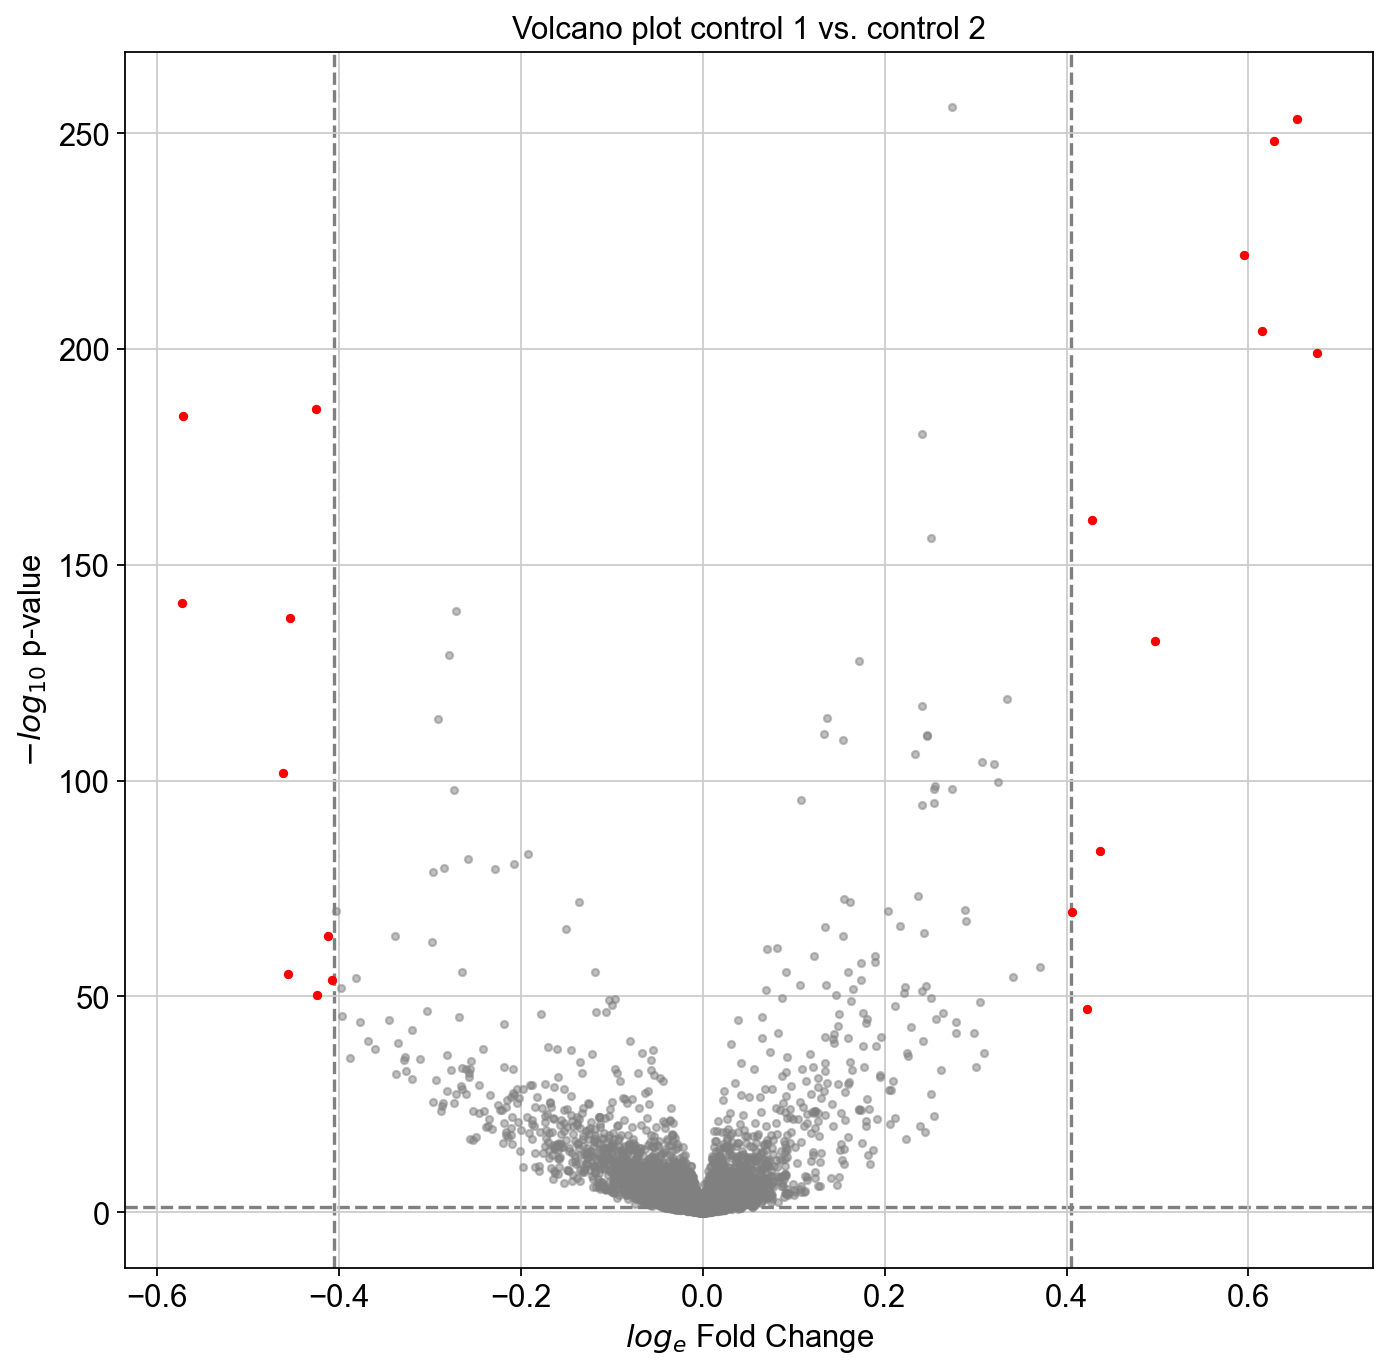

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

alpha=0.05
xline = np.log(1.5) # Set cutoff such that fold change cutoff is 1.5x
yline = -np.log10(alpha)

x = df_volcano["logFC"].values
y = -np.log10(df_volcano["p-value"].values.astype(float))
labels = df_volcano["GeneNames"]

s=10
a=0.5

ax.scatter(x, y, color="grey", s=s, alpha=a)

mask1 = np.logical_and(x>xline, y>yline)
ax.scatter(x[mask1], y[mask1], color="r", s=s, alpha=1)

mask2 = np.logical_and(x<-xline, y>yline)
ax.scatter(x[mask2], y[mask2], color="r", s=s, alpha=1)

mask = np.logical_or(mask1, mask2)

ax.axvline(x=-xline, color="grey", linestyle="--", zorder=-1)
ax.axhline(y=yline, color="grey", linestyle="--", zorder=-1)
ax.axvline(x=xline, color="grey", linestyle="--", zorder=-1)

ax.set(**{
    "xlabel": "$log_e$ Fold Change",
    "ylabel": "$-log_{10}$ p-value",
    "title": "Volcano plot control 1 vs. control 2"
})

plt.savefig("figures/1_volcano_ctrl1-vs-ctrl2.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/1_volcano_ctrl1-vs-ctrl2.pdf", dpi=300, bbox_inches="tight")

ax.set_axisbelow(True)

fig.show()

### Experiment 1 vs Experiment 2

In [74]:
all_data = adata_experiment
condition1_data = adata_experiment[adata_experiment.obs["batch"]=="experiment1"]
condition2_data = adata_experiment[adata_experiment.obs["batch"]=="experiment2"]

Compute dataframe comparing the two datasets:

In [75]:
# Create df
df_volcano = pd.DataFrame()

control = np.array(condition1_data.X.mean(axis=0))[0]
experiment = np.array(condition2_data.X.mean(axis=0))[0]

## Add columns with gene names and mean counts for each gene for each batch
df_volcano["GeneNames"] = all_data.var.index
df_volcano["control"] = control
df_volcano["experiment"] = experiment

## Compute log fold change
# Since we already normalized and logged the values, we just subtract them from each other in order to get the log fold change.
df_volcano["logFC"] = df_volcano["control"] - df_volcano["experiment"]
df_volcano["logFC"] = df_volcano["logFC"].fillna(0)

## Compute p-value
df_volcano["p-value"] = 0
# Dense sparse matrices
matrix_1 = condition1_data.X.todense()
matrix_2 = condition2_data.X.todense()
# Compute and save p-value
_, df_volcano["p-value"] = stats.ttest_ind(matrix_1, matrix_2, equal_var=False)

# df_volcano = df_volcano.dropna()
df_volcano.head()

GeneNames   control  experiment     logFC       p-value
0                WRE_WRE  0.009829    0.007302  0.002527  2.091010e-01
1  _ENSTGUG00000027167.1  0.000588    0.000238  0.000350  4.209934e-01
2  _ENSTGUG00000024634.1  0.028292    0.062824 -0.034532  9.557639e-18
3  _ENSTGUG00000025332.1  0.012898    0.006192  0.006707  9.458408e-05
4  _ENSTGUG00000029184.1  0.000268    0.000389 -0.000121  6.738605e-01

Get all DE genes:

In [76]:
mask1 = np.logical_or(df_volcano["logFC"]>np.log(1.5), df_volcano["logFC"]<-np.log(1.5))
mask2 = df_volcano[mask1]["p-value"]<0.05
de_genes = df_volcano[mask1][mask2]["GeneNames"].values

# Get info on DE genes
de_genes_clean = []
for gene in de_genes:
    de_genes_clean.append(gene.split("_")[1])
df = gget.info(de_genes_clean, wrap_text=True)

Tue Jun 14 15:53:17 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000019084. Returning all unreviewed results.
Tue Jun 14 15:53:19 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000021692. Returning all unreviewed results.
Tue Jun 14 15:53:23 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000009051. Returning all unreviewed results.
Tue Jun 14 15:53:27 2022 WARNING No UniProt entry was found for Ensembl ID ENSTGUG00000023841.
Tue Jun 14 15:53:31 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000027908. Returning all unreviewed results.
Tue Jun 14 15:53:36 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000028547. Returning all unreviewed results.
Tue Jun 14 15:53:40 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSTGUG00000019689. Returning all unreviewed results.
Tue Jun 14 15:53:43 2022 WARNING No UniProt entry was found

Plot volcano plot:

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


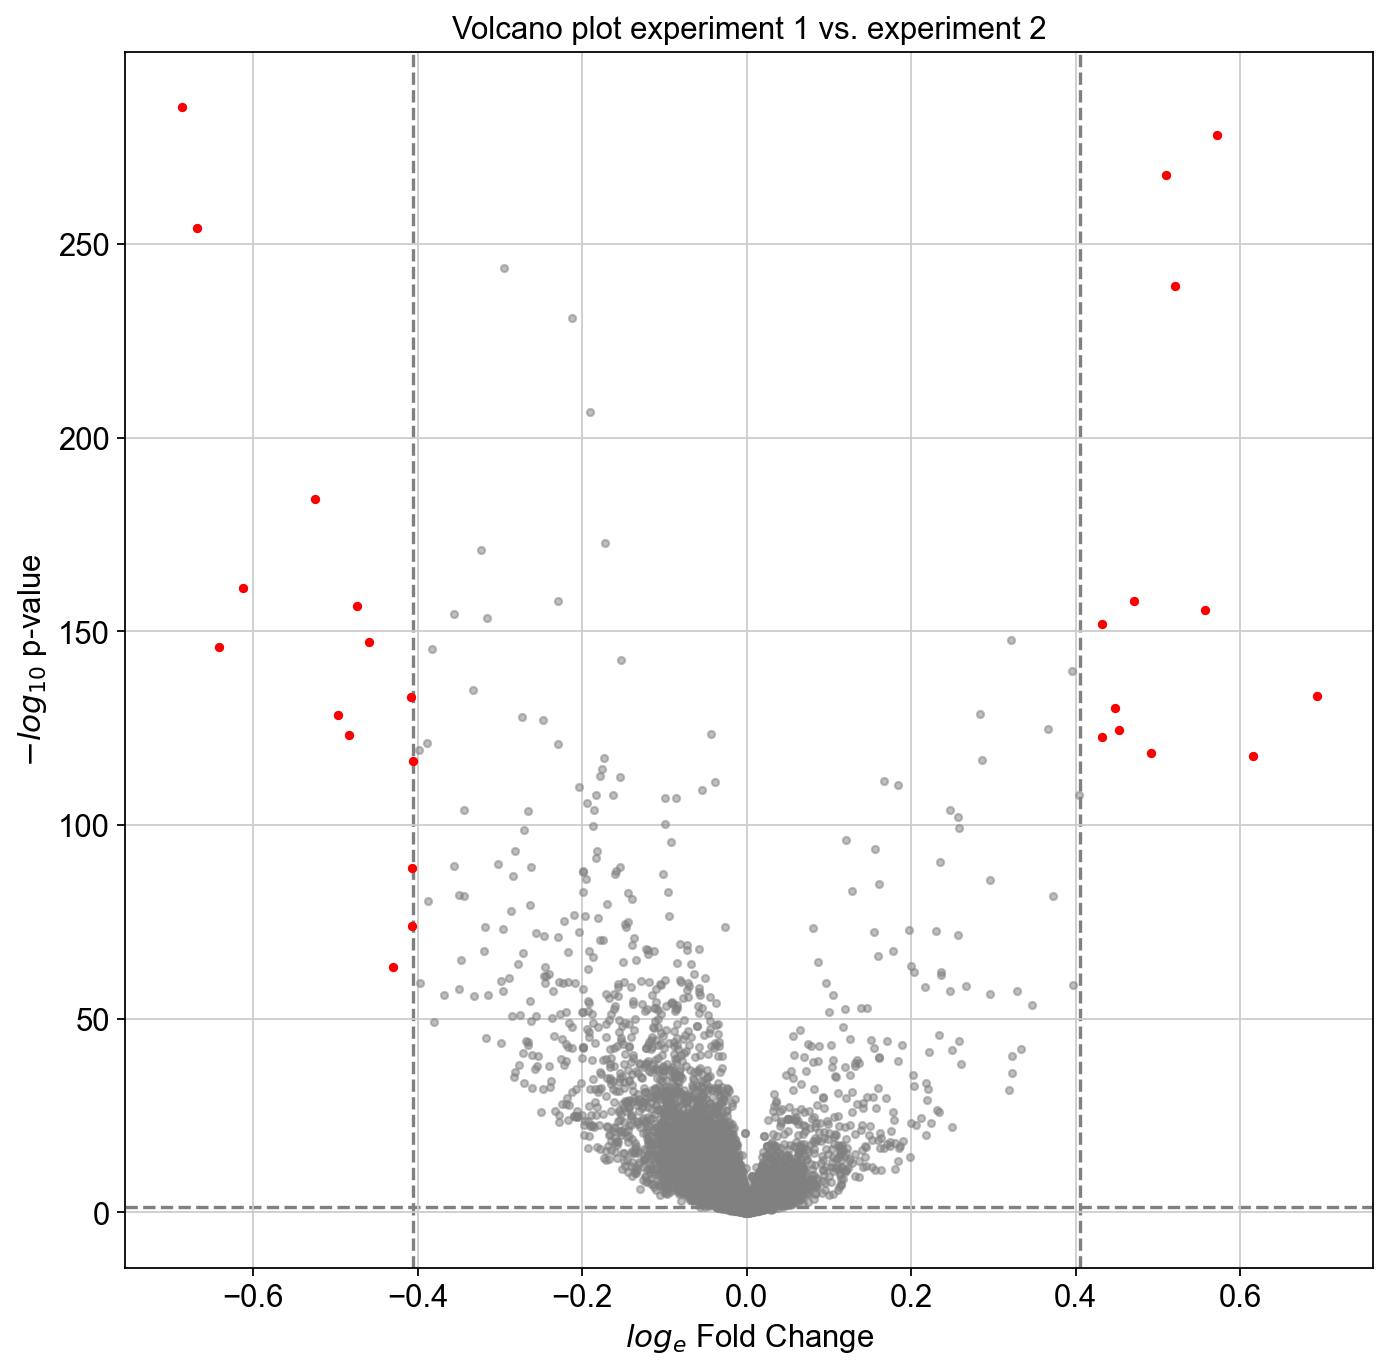

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))

alpha=0.05
xline = np.log(1.5) # Set cutoff such that fold change cutoff is 1.5x
yline = -np.log10(alpha)

x = df_volcano["logFC"].values
y = -np.log10(df_volcano["p-value"].values.astype(float))
labels = df_volcano["GeneNames"]

s=10
a=0.5

ax.scatter(x, y, color="grey", s=s, alpha=a)

mask1 = np.logical_and(x>xline, y>yline)
ax.scatter(x[mask1], y[mask1], color="r", s=s, alpha=1)

mask2 = np.logical_and(x<-xline, y>yline)
ax.scatter(x[mask2], y[mask2], color="r", s=s, alpha=1)

mask = np.logical_or(mask1, mask2)

ax.axvline(x=-xline, color="grey", linestyle="--", zorder=-1)
ax.axhline(y=yline, color="grey", linestyle="--", zorder=-1)
ax.axvline(x=xline, color="grey", linestyle="--", zorder=-1)

ax.set(**{
    "xlabel": "$log_e$ Fold Change",
    "ylabel": "$-log_{10}$ p-value",
    "title": "Volcano plot experiment 1 vs. experiment 2"
})

plt.savefig("figures/1_volcano_exp1-vs-exp2.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/1_volcano_exp1-vs-exp2.pdf", dpi=300, bbox_inches="tight")

ax.set_axisbelow(True)

fig.show()

___

# Concatenate scvi batch corrected datasets and save AnnData object

In [ ]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_scvi = adata_control_scvi.concatenate(adata_experiment_scvi,
                             join='outer', 
                             batch_key='batch_index', 
                             batch_categories=None, 
                             uns_merge=None,
                             fill_value=np.nan)

___

## Perform scvi differential expression?
https://docs.scvi-tools.org/en/stable/user_guide/notebooks/api_overview.html